In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %% Install + imports
!pip -q install xgboost==2.0.3

import os, glob
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    brier_score_loss, accuracy_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
import xgboost as xgb
from xgboost.callback import EarlyStopping
import matplotlib.pyplot as plt

# =========================
# CONFIG (use NON-SLIM v4 files)
# =========================
ROOT      = "/content/drive/MyDrive/Winrate predictions"   # <- change if needed
PATTERN   = os.path.join(
    ROOT, "**",
    "*_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx"
)
OUT_DIR   = ROOT
SEED      = 42
BALL_SUM  = 6
K_FOLDS   = 3            # try 2/3/5
ALPHA     = 0.5          # final blend: (1-ALPHA)*AVG_sym + ALPHA*MONO_NK_sym

# Optional: gather files now and EXCLUDE any accidental SLIM variants
ALL_FILES = sorted(glob.glob(PATTERN, recursive=True))
FILES = [f for f in ALL_FILES if "SLIM" not in os.path.basename(f).upper()]
print(f"Found {len(FILES)} non-SLIM v4 file(s).")
for f in FILES[:5]:
    print(" •", f)


Found 58 non-SLIM v4 file(s).
 • /content/drive/MyDrive/Winrate predictions/01d7c3a8-0625-4e71-adc1-6420cc0f5390_data_files/01d7c3a8-0625-4e71-adc1-6420cc0f5390_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
 • /content/drive/MyDrive/Winrate predictions/06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_data_files/06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
 • /content/drive/MyDrive/Winrate predictions/0e175f77-448e-43f0-bf41-7db72a16a8b9_data_files/0e175f77-448e-43f0-bf41-7db72a16a8b9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
 • /content/drive/MyDrive/Winrate predictions/156b984e-956f-40b1-a1f6-06e955fd7ace_data_files/156b984e-956f-40b1-a1f6-06e955fd7ace_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
 • /content/drive/MyDrive/Winrate predictions/20b66b9a-d853-4687-b955-f9e96ce40330_data_files/20b66b9a-d853-4687-b955-f9e96ce40330_events_with_phase1_tags_by_nearest_time_with_ball_count

In [ ]:
# =========================
# Helpers
# =========================
def norm_col(s):
    return str(s).strip().lower().replace(" ", "_")

def is_end(row):
    dk = str(row.get("definitionkey","")).strip().lower()
    t  = str(row.get("title","")).strip().lower()
    return (dk in {"point_win","point_lose"}) or (t in {"point_win","point_lose"})

def outcome_from_end(last_row):
    dk = str(last_row.get("definitionkey","")).strip().lower()
    t  = str(last_row.get("title","")).strip().lower()
    key = dk if dk in {"point_win","point_lose"} else t
    if key == "point_win":  return 1  # team0 wins set
    if key == "point_lose": return 0  # team1 wins set
    return np.nan

def _standardize_phase1_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Make sure the throw-type column is present and named 'phase1_category'.
    Handles a few common variants (truncation / typos in exports).
    """
    cand = [
        "phase1_category", "phase1_cat", "phase1_categ",
        "p1_category", "phase1", "se1_category", "se1_cate"
    ]
    found = [c for c in df.columns if c in cand]
    if found and "phase1_category" not in df.columns:
        df = df.rename(columns={found[0]: "phase1_category"})
    if "phase1_category" not in df.columns:
        df["phase1_category"] = "unknown"
    df["phase1_category"] = df["phase1_category"].astype("string").fillna("unknown")
    return df

def load_file(fp):
    df = pd.read_excel(fp)
    df.columns = [norm_col(c) for c in df.columns]
    df = df.rename(columns={
        "team_0_left":"team0_left",
        "team_1_left":"team1_left",
        "ball__t1":"ball_t1"
    })
    # ensure phase1_category exists (robust)
    df = _standardize_phase1_category(df)

    for c in ["team0_left","team1_left","ball_t0","ball_t1","time","eventid","team"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    sort_cols = [c for c in ["reviewid","eventid","time"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)
    else:
        df = df.reset_index(drop=True)
    return df

def eval_block(name, y_true, proba):
    proba = np.clip(proba, 1e-7, 1 - 1e-7)
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    ll  = log_loss(y_true, proba)
    br  = brier_score_loss(y_true, proba)
    acc = accuracy_score(y_true, (proba >= 0.5).astype(int))
    print(f"{name}: AUC={auc:.4f}  AP={ap:.4f}  LogLoss={ll:.4f}  Brier={br:.4f}  Acc@0.5={acc:.4f}")
    return {"model":name,"AUC":auc,"AP":ap,"LogLoss":ll,"Brier":br,"Acc@0.5":acc}

def _safe_logloss(y, p):
    p = np.clip(p, 1e-7, 1-1e-7)
    return log_loss(y, p, labels=[0,1])


In [ ]:
# =========================
# Build dataset + MIRROR AUGMENTATION  (with is_throw / thrower_team / prethrow balls)
# =========================
files = sorted(glob.glob(PATTERN, recursive=True))
assert files, f"No files found for {PATTERN}"
print(f"Found {len(files)} files")

rows = []
for fp in files:
    try:
        df = load_file(fp)  # <- your helper normalizes col names and adds phase1_category
        need = {"definitionkey","title","ball_t0","ball_t1","team0_left","team1_left","time"}
        if not need.issubset(df.columns):
            print("[Skip] missing cols in", os.path.basename(fp));
            continue

        # add set_id by cumulative ends within review
        if "reviewid" not in df.columns:
            df["reviewid"] = "unknown"

        end_flag = df.apply(is_end, axis=1).astype(int)
        df["set_end_flag"] = end_flag
        df["cumsum_end"]   = df.groupby("reviewid")["set_end_flag"].cumsum()
        df["set_id"]       = (df["cumsum_end"] - df["set_end_flag"]).astype(int)

        for (rid, sid), g in df.groupby(["reviewid","set_id"], sort=False):
            g = g.sort_values("time").reset_index(drop=True)

            last = g.iloc[-1]
            if not is_end(last):
                continue
            y_team0 = outcome_from_end(last)
            if np.isnan(y_team0):
                continue

            mask = (
                g["ball_t0"].notna() & g["ball_t1"].notna() &
                g["team0_left"].notna() & g["team1_left"].notna()
            )

            cols = ["reviewid","set_id","time","team0_left","team1_left","ball_t0","ball_t1"]
            # bring through throw info if present
            if "is_throw" in g.columns: cols.append("is_throw")
            if "team" in g.columns:     cols.append("team")  # we'll use this to make thrower_team
            if "phase1_category" in g.columns: cols.append("phase1_category")

            gg = g.loc[mask, cols].copy()
            if gg.empty:
                continue

            # standardize / fill throw fields
            if "is_throw" not in gg.columns:
                gg["is_throw"] = False
            gg["is_throw"] = gg["is_throw"].astype(bool)

            # thrower team only on throw rows (from 'team' col if available)
            if "team" in gg.columns:
                gg["thrower_team"] = np.where(gg["is_throw"], gg["team"], np.nan)
                gg = gg.drop(columns=["team"])
            else:
                gg["thrower_team"] = np.nan

            if "phase1_category" not in gg.columns:
                gg["phase1_category"] = "unknown"
            gg["phase1_category"] = gg["phase1_category"].astype("string").fillna("unknown")

            # basic fields
            gg["t0"] = gg["team0_left"].astype(int)
            gg["t1"] = gg["team1_left"].astype(int)
            gg["b0"] = gg["ball_t0"].astype(int)
            gg["b1"] = gg["ball_t1"].astype(int)

            # prethrow balls = previous row's balls within the same set (fallback to current if first row)
            gg["b0_prethrow"] = gg["b0"]
            gg["b1_prethrow"] = gg["b1"]
            prev_b0 = gg["b0"].shift(1)
            prev_b1 = gg["b1"].shift(1)
            throw_mask = gg["is_throw"]
            gg.loc[throw_mask, "b0_prethrow"] = prev_b0.where(prev_b0.notna(), gg["b0"])[throw_mask]
            gg.loc[throw_mask, "b1_prethrow"] = prev_b1.where(prev_b1.notna(), gg["b1"])[throw_mask]

            # housekeeping
            gg["row_idx"]  = np.arange(len(gg))
            gg["row_frac"] = (gg["row_idx"] + 1) / len(gg)
            gg["reviewid"] = g["reviewid"].iloc[0].astype(str) if hasattr(g["reviewid"].iloc[0], "astype") else str(g["reviewid"].iloc[0])
            gg["set_key"]  = gg["reviewid"].astype(str) + "_" + gg["set_id"].astype(int).astype(str)

            # only states with full ball sum
            gg = gg[(gg["b0"] + gg["b1"]) == BALL_SUM].copy()
            if gg.empty:
                continue

            gg["y"] = int(y_team0)

            rows.append(gg[[
                "reviewid","set_id","set_key","time","row_idx","row_frac",
                "t0","t1","b0","b1",
                "b0_prethrow","b1_prethrow",
                "is_throw","thrower_team","phase1_category",
                "y"
            ]])

    except Exception as e:
        print("[Error]", os.path.basename(fp), "->", e)

base = pd.concat(rows, ignore_index=True)
print("Base rows:", len(base), "| sets:", base["set_key"].nunique())

# Mirror augmentation (swap sides; flip label). Throw-type stays the same.
mir = base.copy()
mir[["t0","t1"]] = base[["t1","t0"]].values
mir[["b0","b1"]] = base[["b1","b0"]].values
mir[["b0_prethrow","b1_prethrow"]] = base[["b1_prethrow","b0_prethrow"]].values
mir["y"]         = 1 - base["y"].values
mir["is_mirror"] = 1
base["is_mirror"]= 0
data = pd.concat([base, mir], ignore_index=True)
print("After mirroring, rows:", len(data))

# Categorical features (for XGB-cat & LR)
data["players_pair_cat"] = (data["t0"].astype("Int64").astype(str)
                            + "_" + data["t1"].astype("Int64").astype(str))
data["ball_t0_cat"]      = data["b0"].astype("Int64")

players_pairs_all = [f"{i}_{j}" for i in range(7) for j in range(7)]
ball_states_all   = list(range(7))
data["players_pair_cat"] = pd.Categorical(data["players_pair_cat"],
                                          categories=players_pairs_all, ordered=False)
data["ball_t0_cat"]      = pd.Categorical(data["ball_t0_cat"],
                                          categories=ball_states_all,   ordered=False)

TARGET    = "y"
CAT_FEATS = ["players_pair_cat","ball_t0_cat"]
KEEP_COLS = ["reviewid","set_id","set_key","time","row_idx","row_frac","is_mirror",
             "t0","t1","b0","b1","b0_prethrow","b1_prethrow","is_throw","thrower_team",
             "phase1_category"] + CAT_FEATS + [TARGET]

# (Optional) sanity check before K-fold
must_have = {"is_throw","b0_prethrow","b1_prethrow","thrower_team"}
missing = must_have - set(data.columns)
assert not missing, f"Missing required columns: {missing}"


Found 58 files
Base rows: 24107 | sets: 761
After mirroring, rows: 48214


In [ ]:
# =========================
# NEXT-KILL (NK) HELPERS — pre-throw reconstruction
# =========================
def _nk_rows_from_base_group(g, ball_sum=6):
    """
    For a single set_key group in *base* (sorted by time):
      - Iterate rows k = 1..n-1 (each is a throw row)
      - Infer the thrower at k from ball deltas vs k-1
      - Reconstruct PRE-THROW ball counts for k
      - Use players from k-1 (pre-throw) as well
      - Label y_nk_team0 = 1 if row k decreases team1_left (team0 got the kill), else 0
        (no-kill rows are labeled 0)
    """
    g = g.sort_values("time").reset_index(drop=True)
    n = len(g)
    if n < 2:
        return []

    out = []
    for k in range(1, n):
        i = k - 1

        # players (pre-throw) come from the previous row
        t0_prev = int(g.at[i, "t0"])
        t1_prev = int(g.at[i, "t1"])

        # post-throw ball counts (what's actually recorded at row k)
        b0_post = int(g.at[k, "b0"])
        b1_post = int(g.at[k, "b1"])

        # ball deltas to infer thrower at row k
        db0 = b0_post - int(g.at[i, "b0"])
        db1 = b1_post - int(g.at[i, "b1"])

        if db0 == -1 and db1 == +1:
            thrower = "team0"
            b0_pre = b0_post + 1
            b1_pre = b1_post - 1
        elif db0 == +1 and db1 == -1:
            thrower = "team1"
            b0_pre = b0_post - 1
            b1_pre = b1_post + 1
        else:
            # Ambiguous / non-single-ball transfer:
            # fall back to using previous-row balls as the pre-throw state.
            thrower = "unknown"
            b0_pre = int(g.at[i, "b0"])
            b1_pre = int(g.at[i, "b1"])

        # Clip & enforce sum just in case
        b0_pre = max(0, min(ball_sum, b0_pre))
        b1_pre = max(0, min(ball_sum, b1_pre))
        # If you want, you could also force b1_pre = ball_sum - b0_pre

        # Did team0 get the kill at row k?
        # (team1_left decreases => team0 kill)
        team0_kill = int(g.at[k, "t1"] < g.at[i, "t1"])

        out.append({
            "reviewid": g.at[i, "reviewid"],
            "set_id":   g.at[i, "set_id"],
            "set_key":  g.at[i, "set_key"],
            "pre_idx":  int(i),
            "throw_idx": int(k),
            "t0_prev":  t0_prev,
            "t1_prev":  t1_prev,
            "b0_prev":  b0_pre,
            "b1_prev":  b1_pre,
            "player_adv_prev":     int(t0_prev - t1_prev),
            "players_total_prev":  int(t0_prev + t1_prev),
            "ball_adv_prev":       int(b0_pre - b1_pre),
            "thrower_at_k":        thrower,          # optional, for sanity checks
            "y_nk_team0":          team0_kill,       # label: did this throw get a kill for team0?
        })

    return out


def build_nextkill_df_mirrored(base_df, ball_sum=6):
    """
    Build NK dataset from *base* (non-mirrored) using pre-throw reconstruction,
    then mirror it (swap sides and flip label).
    """
    rows = []
    for sk, grp in base_df.groupby("set_key", sort=False):
        rows.extend(_nk_rows_from_base_group(grp, ball_sum=ball_sum))

    nk = pd.DataFrame(rows)
    if nk.empty:
        return nk

    # Mirror NK rows: swap sides and flip label
    mir = nk.copy()
    mir[["t0_prev","t1_prev"]] = nk[["t1_prev","t0_prev"]].values
    mir[["b0_prev","b1_prev"]] = nk[["b1_prev","b0_prev"]].values
    mir["player_adv_prev"]     = -nk["player_adv_prev"].values
    mir["ball_adv_prev"]       = -nk["ball_adv_prev"].values
    # players_total_prev unchanged
    mir["y_nk_team0"]          = 1 - nk["y_nk_team0"].values
    nk_all = pd.concat([nk, mir], ignore_index=True)
    return nk_all


def fit_nk_model(nk_train, nk_val, seed=1234):
    """Train NK model (binary: next kill by team0) with monotone + on ball_adv_prev & player_adv_prev."""
    feats = ["player_adv_prev","players_total_prev","ball_adv_prev"]
    mono  = (1, 0, 1)  # + on player_adv & ball_adv, 0 on total
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method="hist",
        monotone_constraints=mono,
        eval_metric="logloss",
        random_state=seed,
    )
    callbacks = [EarlyStopping(rounds=100, save_best=True, maximize=False)]
    model.fit(
        nk_train[feats], nk_train["y_nk_team0"].values,
        eval_set=[(nk_train[feats], nk_train["y_nk_team0"].values),
                  (nk_val[feats],   nk_val["y_nk_team0"].values)],
        callbacks=callbacks, verbose=False
    )
    return model


def nk_predict_sym(model, t0, t1, b0, b1):
    """
    Symmetrized P(team0 gets next kill) for vector inputs.
    NOTE: These features should be the *pre-throw* state you feed at inference.
    """
    feats = pd.DataFrame({
        "player_adv_prev": t0 - t1,
        "players_total_prev": t0 + t1,
        "ball_adv_prev": b0 - b1
    })
    p = model.predict_proba(feats)[:,1]
    # mirror
    feats_m = feats.copy()
    feats_m["player_adv_prev"] = -feats_m["player_adv_prev"]
    feats_m["ball_adv_prev"]   = -feats_m["ball_adv_prev"]
    p_m = model.predict_proba(feats_m)[:,1]
    return 0.5*(p + (1 - p_m))


In [ ]:
# =========================
# Build NK dataset (once) from base
# =========================
nk_all = build_nextkill_df_mirrored(base)
print("NK rows (mirrored):", len(nk_all))


NK rows (mirrored): 46692


In [ ]:
# ==== One-cell XGBoost fit shim (safe across versions) ====
import inspect
from xgboost import XGBClassifier
try:
    from xgboost.callback import EarlyStopping
except Exception:
    EarlyStopping = None

def xgb_fit_auto(clf, X_tr, y_tr, X_va=None, y_va=None, n_rounds=100, verbose=False):
    """Fits XGBClassifier with early stopping across xgboost versions."""
    eval_set = [(X_va, y_va)] if (X_va is not None and y_va is not None) else None
    # Newer sklearn wrapper supports 'callbacks'; older uses 'early_stopping_rounds'
    if eval_set is not None and EarlyStopping is not None and "callbacks" in inspect.signature(clf.fit).parameters:
        cb = [EarlyStopping(rounds=n_rounds, save_best=True, maximize=False)]
        return clf.fit(X_tr, y_tr, eval_set=eval_set, callbacks=cb, verbose=verbose)
    else:
        kwargs = {}
        if eval_set is not None:
            kwargs["eval_set"] = eval_set
            kwargs["early_stopping_rounds"] = n_rounds
        return clf.fit(X_tr, y_tr, verbose=verbose, **kwargs)

def align_cats(train_df, valid_df, cat_cols):
    """Make pandas categorical columns compatible across splits."""
    for c in cat_cols:
        train_df[c] = train_df[c].astype("category")
        if valid_df is not None:
            valid_df[c] = valid_df[c].astype("category").cat.set_categories(train_df[c].cat.categories)


In [ ]:
# =========================
# THREAT-AWARE K-FOLD (prethrow + monotone + counterfactual threat)
# Version-agnostic XGBoost (no callbacks/ES errors) + no SettingWithCopy warnings
# =========================
import os, inspect, warnings
import numpy as np, pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import xgboost as xgb

# =========================
# Helpers: safe categorical alignment + xgboost fit that works on any version
# =========================
def set_cat_levels_inplace(df_target: pd.DataFrame, df_ref: pd.DataFrame, cols):
    """
    Align pandas 'category' dtypes in df_target to df_ref for the given columns,
    using .loc[...] to avoid SettingWithCopyWarning.
    """
    for c in cols:
        if c not in df_target.columns or c not in df_ref.columns:
            continue
        if not pd.api.types.is_categorical_dtype(df_ref[c]):
            df_ref.loc[:, c] = df_ref[c].astype("category")
        if not pd.api.types.is_categorical_dtype(df_target[c]):
            df_target.loc[:, c] = df_target[c].astype("category")
        df_target.loc[:, c] = df_target[c].cat.set_categories(df_ref[c].cat.categories)

# Try callback import (may not exist in older builds)
try:
    from xgboost.callback import EarlyStopping as _XGB_EarlyStopping
except Exception:
    _XGB_EarlyStopping = None

def _fit_with_callbacks_or_es(clf, X_tr, y_tr, X_va=None, y_va=None, n_rounds=100, verbose=False):
    """Attempt to use callbacks or early_stopping_rounds if supported by this build."""
    params = inspect.signature(clf.fit).parameters
    supports_callbacks = ("callbacks" in params) and (_XGB_EarlyStopping is not None)
    supports_es_rounds = "early_stopping_rounds" in params
    supports_eval_set  = "eval_set" in params
    supports_verbose   = "verbose" in params

    kwargs = {}
    if supports_eval_set and X_va is not None and y_va is not None:
        kwargs["eval_set"] = [(X_va, y_va)]
        if supports_callbacks:
            kwargs["callbacks"] = [_XGB_EarlyStopping(rounds=n_rounds, save_best=True, maximize=False)]
        elif supports_es_rounds:
            kwargs["early_stopping_rounds"] = n_rounds
    if supports_verbose:
        kwargs["verbose"] = verbose

    return clf.fit(X_tr, y_tr, **kwargs)

from sklearn.base import clone
def _fit_with_grid_fallback(clf, X_tr, y_tr, X_va, y_va, cand_rounds=(300, 600, 1000), verbose=False):
    """
    Manual early-stopping fallback for wrappers with no callbacks/ES support.
    Train a few n_estimators and pick the best on val by logloss, then refit on train+val.
    """
    best_loss, best_clf, best_n = np.inf, None, None
    for n in cand_rounds:
        tmp = clone(clf).set_params(n_estimators=int(n))
        tmp.fit(X_tr, y_tr)
        p = np.clip(tmp.predict_proba(X_va)[:, 1], 1e-7, 1-1e-7)
        loss = log_loss(y_va, p, labels=[0, 1])
        if verbose:
            print(f"[xgb grid] n_estimators={n} -> val LogLoss={loss:.4f}")
        if loss < best_loss:
            best_loss, best_clf, best_n = loss, tmp, int(n)
    if verbose:
        print(f"[xgb grid] selected n_estimators={best_n} (LogLoss={best_loss:.4f})")

    final = clone(clf).set_params(n_estimators=best_n)
    X_all = X_tr if X_va is None else pd.concat([X_tr, X_va], axis=0)
    y_all = y_tr if y_va is None else np.concatenate([y_tr, y_va], axis=0)
    final.fit(X_all, y_all)
    clf.__dict__.update(final.__dict__)
    return clf

def xgb_fit_any(clf, X_tr, y_tr, X_va=None, y_va=None, n_rounds=100, verbose=False):
    """
    Unified, version-agnostic XGBClassifier fit:
      1) Try callbacks / early_stopping_rounds if supported.
      2) If TypeError (unsupported kwarg), fall back to tiny grid over n_estimators.
    """
    try:
        return _fit_with_callbacks_or_es(clf, X_tr, y_tr, X_va, y_va, n_rounds=n_rounds, verbose=verbose)
    except TypeError as e:
        if verbose:
            print("[xgb_fit_any] Falling back to grid search because:", e)
        if X_va is None or y_va is None:
            # If no val set provided, just fit without early stopping.
            return clf.fit(X_tr, y_tr)
        return _fit_with_grid_fallback(clf, X_tr, y_tr, X_va, y_va, cand_rounds=(300, 600, 1000), verbose=verbose)

# =========================
# Metrics helper
# =========================
def _eval_block(name, y_true, proba):
    from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss, accuracy_score
    p = np.clip(np.asarray(proba), 1e-7, 1-1e-7)
    print(f"{name}: AUC={roc_auc_score(y_true,p):.4f}  AP={average_precision_score(y_true,p):.4f}  "
          f"LogLoss={log_loss(y_true,p):.4f}  Brier={brier_score_loss(y_true,p):.4f}  Acc@0.5={accuracy_score(y_true,(p>=0.5).astype(int)):.4f}")
    return {"model":name,"AUC":roc_auc_score(y_true,p),"AP":average_precision_score(y_true,p),
            "LogLoss":log_loss(y_true,p),"Brier":brier_score_loss(y_true,p),"Acc@0.5":accuracy_score(y_true,(p>=0.5).astype(int))}

# =========================
# NK model (+ symmetric prediction)
# =========================
def fit_nk_model(nk_train, nk_val, seed=1234):
    feats = ["player_adv_prev","players_total_prev","ball_adv_prev"]
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=2000, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, tree_method="hist",
        monotone_constraints=(1,0,1), eval_metric="logloss", random_state=seed
    )
    xgb_fit_any(
        model,
        nk_train[feats], nk_train["y_nk_team0"].values,
        nk_val[feats],   nk_val["y_nk_team0"].values,
        n_rounds=100, verbose=False
    )
    return model

def nk_predict_sym(model, t0, t1, b0_pre, b1_pre):
    feats = pd.DataFrame({
        "player_adv_prev": t0 - t1,
        "players_total_prev": t0 + t1,
        "ball_adv_prev": b0_pre - b1_pre
    })
    p = model.predict_proba(feats)[:,1]
    feats_m = feats.copy()
    feats_m["player_adv_prev"] *= -1
    feats_m["ball_adv_prev"]   *= -1
    pm = model.predict_proba(feats_m)[:,1]
    return 0.5*(p + (1 - pm))

# =========================
# Empirical ball-flow deltas for throws (survive / hit)
# =========================
def estimate_throw_outcome_ball_deltas(base_df, ball_sum):
    rows = []
    for sk, g in base_df.groupby("set_key", sort=False):
        g = g.sort_values("time").reset_index(drop=True)
        for i in range(len(g)-1):
            r, r2 = g.iloc[i], g.iloc[i+1]
            if int(r.get("is_throw",0)) != 1 or pd.isna(r.get("thrower_team", pd.NA)):
                continue
            # who killed at next row?
            t0_drop = (r2["t0"] < r["t0"])
            t1_drop = (r2["t1"] < r["t1"])
            if t0_drop == t1_drop:  # both/none => ambiguous, treat as survive
                hit = False
            else:
                killer = 1 if t0_drop else 0
                hit = (killer == int(r["thrower_team"]))
            # deltas vs PRE-THROW balls
            db0 = int(r2["b0"] - r["b0_prethrow"])
            db1 = int(r2["b1"] - r["b1_prethrow"])
            attacker = int(r["thrower_team"])
            # canonicalize deltas to attacker=team1
            if attacker == 1:
                db0_c, db1_c = db0, db1
            else:
                db0_c, db1_c = -db1, -db0
            rows.append({"hit": int(hit), "db0_c": db0_c, "db1_c": db1_c})
    emp = pd.DataFrame(rows)
    if emp.empty:
        print("[warn] no throw rows; using defaults")
        return {"survive": (1,-1), "hit": (0,0)}
    d_surv = emp[emp["hit"]==0][["db0_c","db1_c"]].mean().round().astype(int).tolist()
    d_hit  = emp[emp["hit"]==1][["db0_c","db1_c"]].mean().round().astype(int).tolist()
    if not np.isfinite(d_surv[0]): d_surv = [1,-1]
    if not np.isfinite(d_hit[0]):  d_hit  = [0,0]
    deltas = {"survive": tuple(d_surv), "hit": tuple(d_hit)}
    print("Empirical throw deltas (canonical attacker=team1):", deltas)
    return deltas

# expects: base, BALL_SUM defined upstream
THROW_DELTAS = estimate_throw_outcome_ball_deltas(base, BALL_SUM)

# =========================
# Diagnostic categorical scorer (not used in final)
# =========================
def sym_pred_cat(xgb_clf, logreg, df_state, players_pairs_all, ball_states_all):
    pp   = (df_state["t0"].astype("Int64").astype(str) + "_" + df_state["t1"].astype("Int64").astype(str)).astype("category").cat.set_categories(players_pairs_all)
    bcat =  df_state["b0"].astype("Int64").astype("category").cat.set_categories(ball_states_all)
    X    = pd.DataFrame({"players_pair_cat": pp, "ball_t0_cat": bcat})
    p1   = xgb_clf.predict_proba(X)[:,1]
    p2   = logreg.predict_proba(X)[:,1]
    # mirror for symmetry
    pp_m   = (df_state["t1"].astype("Int64").astype(str) + "_" + df_state["t0"].astype("Int64").astype(str)).astype("category").cat.set_categories(players_pairs_all)
    bcat_m =  df_state["b1"].astype("Int64").astype("category").cat.set_categories(ball_states_all)
    Xm     = pd.DataFrame({"players_pair_cat": pp_m, "ball_t0_cat": bcat_m})
    p1_m   = xgb_clf.predict_proba(Xm)[:,1]
    p2_m   = logreg.predict_proba(Xm)[:,1]
    return 0.5 * (0.5*(p1 + (1 - p1_m)) + 0.5*(p2 + (1 - p2_m)))

# =========================
# Counterfactual threat using a *monotone base* scorer
# =========================
def score_with_mono_base(mono_base, nk_model, t0, t1, b0, b1):
    p_nk  = nk_predict_sym(nk_model, t0, t1, b0, b1)
    nkadv = 2*(p_nk - 0.5)
    feats = pd.DataFrame({
        "player_adv":    t0 - t1,
        "players_total": t0 + t1,
        "ball_adv":      b0 - b1,
        "nk_adv":        nkadv,
    })
    return mono_base.predict_proba(feats)[:,1]

def threat_averted_for_mono(df_rows, deltas, nk_model, mono_base, ball_sum):
    idx   = df_rows.index
    t0    = df_rows["t0"].to_numpy()
    t1    = df_rows["t1"].to_numpy()
    b0pre = df_rows["b0_prethrow"].to_numpy()
    b1pre = df_rows["b1_prethrow"].to_numpy()
    thr   = df_rows["thrower_team"].astype("Int64").to_numpy()
    is_th = (df_rows["is_throw"].to_numpy() == 1) & (~pd.isna(thr))

    # P(hit now) aligned to the thrower side (temporary NK-based; you later replaced with event-level p_hit)
    p_nk_team0 = nk_predict_sym(nk_model, t0, t1, b0pre, b1pre)
    p_hit = np.where(thr == 0, p_nk_team0, 1 - p_nk_team0)

    # canonical deltas (attacker=team1)
    db0_s_c, db1_s_c = deltas["survive"]
    db0_h_c, db1_h_c = deltas["hit"]

    # orient deltas to actual attacker
    db0_s = np.where(thr == 1, db0_s_c, -db1_s_c)
    db1_s = np.where(thr == 1, db1_s_c, -db0_s_c)
    db0_h = np.where(thr == 1, db0_h_c, -db1_h_c)
    db1_h = np.where(thr == 1, db1_h_c, -db0_h_c)

    # SURVIVE branch
    t0_s, t1_s = t0, t1
    b0_s = np.clip(b0pre + db0_s, 0, ball_sum)
    b1_s = np.clip(b1pre + db1_s, 0, ball_sum)
    p_win_s = score_with_mono_base(mono_base, nk_model, t0_s, t1_s, b0_s, b1_s)

    # HIT branch
    t0_h = np.where(thr == 1, np.clip(t0 - 1, 0, 6), t0)
    t1_h = np.where(thr == 0, np.clip(t1 - 1, 0, 6), t1)
    b0_h = np.clip(b0pre + db0_h, 0, ball_sum)
    b1_h = np.clip(b1pre + db1_h, 0, ball_sum)
    p_win_h = score_with_mono_base(mono_base, nk_model, t0_h, t1_h, b0_h, b1_h)

    tv = p_hit * (p_win_s - p_win_h)
    tv = np.where(is_th, tv, 0.0)
    return pd.Series(tv, index=idx, dtype=float)

# =========================
# K-fold (state win-rate uses PRE-THROW balls; final is monotone)
# =========================
if not hasattr(np, "NaN"): np.NaN = np.nan

CATS = ["players_pair_cat","ball_t0_cat"]
# Ensure base data columns are categorical
for c in CATS:
    if c in data.columns and not pd.api.types.is_categorical_dtype(data[c]):
        data.loc[:, c] = data[c].astype("category")

gkf = GroupKFold(n_splits=K_FOLDS)
groups = data["set_key"].values

metrics, pred_rows = [], []
imp_rows_final = []   # collect feature importances across folds
rng = np.random.RandomState(42)
fold_id = 0

for train_idx, test_idx in gkf.split(data, groups=groups):
    fold_id += 1
    tr = data.iloc[train_idx].copy()
    te = data.iloc[test_idx].copy()

    # Align categories safely (no SettingWithCopyWarning)
    set_cat_levels_inplace(tr, data, CATS)
    set_cat_levels_inplace(te, data, CATS)

    y_tr, y_te = tr[TARGET].values, te[TARGET].values

    # internal val split (by set_key)
    tr_sets = tr["set_key"].unique()
    rng.shuffle(tr_sets)
    n_int = max(1, int(0.10 * len(tr_sets)))
    int_val_sets = set(tr_sets[:n_int])
    tr_sub = tr[~tr["set_key"].isin(int_val_sets)].copy()
    va_sub = tr[ tr["set_key"].isin(int_val_sets)].copy()

    # Align categories for the internal splits
    set_cat_levels_inplace(tr_sub, data, CATS)
    set_cat_levels_inplace(va_sub, data, CATS)

    # ---- (A) Cat models (diagnostic)
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic", n_estimators=2000, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, tree_method="hist", enable_categorical=True,
        random_state=1234+fold_id, eval_metric="logloss"
    )
    xgb_fit_any(
        xgb_clf,
        tr_sub[CATS], tr_sub[TARGET].values,
        va_sub[CATS], va_sub[TARGET].values,
        n_rounds=100, verbose=False
    )

    try:
        ohe = OneHotEncoder(categories=[players_pairs_all, ball_states_all], handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(categories=[players_pairs_all, ball_states_all], handle_unknown="ignore", sparse=True)
    logreg = Pipeline([("ohe", ohe), ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=4321+fold_id))])
    logreg.fit(tr[CATS], y_tr)

    def cat_state_prob_prethrow(df):
        b0w = np.where(df["is_throw"]==1, df["b0_prethrow"], df["b0"])
        b1w = np.where(df["is_throw"]==1, df["b1_prethrow"], df["b1"])
        tmp = pd.DataFrame({"t0":df["t0"],"t1":df["t1"],"b0":b0w,"b1":b1w}, index=df.index)
        return sym_pred_cat(xgb_clf, logreg, tmp, players_pairs_all, ball_states_all)

    p_cat_sym = cat_state_prob_prethrow(te)

    # ---- (B) NK on fold's train sets
    if 'nk_all' in globals() and isinstance(nk_all, pd.DataFrame) and not nk_all.empty:
        nk_tr_full = nk_all[nk_all["set_key"].isin(tr["set_key"].unique())].copy()
        nk_sets = nk_tr_full["set_key"].unique()
        rng.shuffle(nk_sets)
        n_int_nk = max(1, int(0.10 * len(nk_sets)))
        nk_val_sets = set(nk_sets[:n_int_nk])
        nk_tr = nk_tr_full[~nk_tr_full["set_key"].isin(nk_val_sets)]
        nk_va = nk_tr_full[ nk_tr_full["set_key"].isin(nk_val_sets)]
        nk_model = fit_nk_model(nk_tr, nk_va, seed=999+fold_id) if (len(nk_tr)>=20 and not nk_va.empty) else None
    else:
        nk_model = None

    def nk_dir_prob(df):
        if nk_model is None:
            return pd.Series(0.5, index=df.index)
        p = nk_predict_sym(nk_model, df["t0"].values, df["t1"].values, df["b0_prethrow"].values, df["b1_prethrow"].values)
        return pd.Series(p, index=df.index)

    p_nk_tr = nk_dir_prob(tr)
    p_nk_va = nk_dir_prob(va_sub)
    p_nk_te = nk_dir_prob(te)

    nk_adv_tr = 2*(p_nk_tr - 0.5)
    nk_adv_va = 2*(p_nk_va - 0.5)
    nk_adv_te = 2*(p_nk_te - 0.5)

    # ---- (C) MONOTONE base (prethrow balls)
    def add_numeric_base(df, nk_adv_series):
        return pd.DataFrame({
            "player_adv":    df["t0"].values - df["t1"].values,
            "players_total": df["t0"].values + df["t1"].values,
            "ball_adv":      df["b0_prethrow"].values - df["b1_prethrow"].values,
            "nk_adv":        nk_adv_series.reindex(df.index).to_numpy(),
        }, index=df.index)

    tr_num_base = add_numeric_base(tr_sub, nk_adv_tr)
    va_num_base = add_numeric_base(va_sub, nk_adv_va)

    xgb_mono_base = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=2000, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, tree_method="hist",
        monotone_constraints=(1,0,1,1), eval_metric="logloss", random_state=2023+fold_id
    )
    xgb_fit_any(
        xgb_mono_base,
        tr_num_base, tr_sub[TARGET].values,
        va_num_base, va_sub[TARGET].values,
        n_rounds=100, verbose=False
    )

    # ---- (D) Threat-averted using *monotone base* scorer
    def threat_for(df):
        if nk_model is None:
            return pd.Series(0.0, index=df.index, dtype=float)
        return threat_averted_for_mono(df, THROW_DELTAS, nk_model, xgb_mono_base, BALL_SUM)

    threat_tr = threat_for(tr_sub)
    threat_va = threat_for(va_sub)
    threat_te = threat_for(te)

    # ---- (E) FINAL MONOTONE head (prethrow) with threat_averted
    def add_numeric_final(df, nk_adv_series, threat_series):
        return pd.DataFrame({
            "player_adv":     df["t0"].values - df["t1"].values,
            "players_total":  df["t0"].values + df["t1"].values,
            "ball_adv":       df["b0_prethrow"].values - df["b1_prethrow"].values,
            "nk_adv":         nk_adv_series.reindex(df.index).to_numpy(),
            "threat_averted": threat_series.reindex(df.index).to_numpy(),
        }, index=df.index)

    tr_num = add_numeric_final(tr_sub, nk_adv_tr, threat_tr)
    va_num = add_numeric_final(va_sub, nk_adv_va, threat_va)
    te_num = add_numeric_final(te,     nk_adv_te, threat_te)

    NUM_FEATS = ["player_adv","players_total","ball_adv","nk_adv","threat_averted"]

    xgb_mono_final = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=2000, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, tree_method="hist",
        monotone_constraints=(1,0,1,1,1), eval_metric="logloss", random_state=2024+fold_id
    )
    xgb_fit_any(
        xgb_mono_final,
        tr_num, tr_sub[TARGET].values,
        va_num, va_sub[TARGET].values,
        n_rounds=100, verbose=False
    )

    # symmetrize numeric head
    p_mono_raw  = xgb_mono_final.predict_proba(te_num)[:,1]
    te_num_mirr = te_num.copy()
    te_num_mirr["player_adv"]     *= -1
    te_num_mirr["ball_adv"]       *= -1
    te_num_mirr["nk_adv"]         *= -1
    te_num_mirr["threat_averted"] *= -1
    p_mono_mirr = xgb_mono_final.predict_proba(te_num_mirr)[:,1]
    p_mono_sym  = 0.5 * (p_mono_raw + (1 - p_mono_mirr))

    # HARD CLAMP: exact ties
    tie_mask = (te["t0"].values == te["t1"].values) & (te["b0_prethrow"].values == te["b1_prethrow"].values)
    if tie_mask.any():
        p_mono_sym = np.array(p_mono_sym, copy=True)
        p_mono_sym[tie_mask] = 0.5

    # ---- (F) Metrics & feature importances
    metrics.append(_eval_block(f"CAT_sym (diagnostic) (fold {fold_id})", y_te, p_cat_sym))
    te_num_base = add_numeric_base(te, nk_adv_te)
    metrics.append(_eval_block(f"MONO_base (fold {fold_id})", y_te, xgb_mono_base.predict_proba(te_num_base)[:,1]))
    metrics.append(_eval_block(f"MONO_final (fold {fold_id})", y_te, p_mono_sym))

    # collect importances
    booster = xgb_mono_final.get_booster()
    def _imp(kind):
        d = booster.get_score(importance_type=kind)
        return {f: d.get(f, 0.0) for f in NUM_FEATS}
    imp_rows_final.append({"fold":fold_id, "type":"gain",  **_imp("gain")})
    imp_rows_final.append({"fold":fold_id, "type":"cover", **_imp("cover")})
    imp_rows_final.append({"fold":fold_id, "type":"weight",**_imp("weight")})

    # FINAL prediction
    p_final = p_mono_sym

    # ===== Diagnostics to audit dodge impact =====
    if nk_model is not None:
        thr = te["thrower_team"].astype("Int64").to_numpy()
        b0p, b1p = te["b0_prethrow"].to_numpy(), te["b1_prethrow"].to_numpy()
        t0v, t1v = te["t0"].to_numpy(), te["t1"].to_numpy()

        db0_s_c, db1_s_c = THROW_DELTAS["survive"]
        db0_h_c, db1_h_c = THROW_DELTAS["hit"]
        db0_s = np.where(thr == 1, db0_s_c, -db1_s_c)
        db1_s = np.where(thr == 1, db1_s_c, -db0_s_c)
        db0_h = np.where(thr == 1, db0_h_c, -db1_h_c)
        db1_h = np.where(thr == 1, db1_h_c, -db0_h_c)

        S = pd.DataFrame({
            "t0": t0v, "t1": t1v,
            "b0": np.clip(b0p + db0_s, 0, BALL_SUM),
            "b1": np.clip(b1p + db1_s, 0, BALL_SUM),
        }, index=te.index)
        H = pd.DataFrame({
            "t0": np.where(thr == 1, np.clip(t0v - 1, 0, 6), t0v),
            "t1": np.where(thr == 0, np.clip(t1v - 1, 0, 6), t1v),
            "b0": np.clip(b0p + db0_h, 0, BALL_SUM),
            "b1": np.clip(b1p + db1_h, 0, BALL_SUM),
        }, index=te.index)
        BASE = pd.DataFrame({
            "t0": t0v, "t1": t1v, "b0": b0p, "b1": b1p
        }, index=te.index)

        p_win_survive = score_with_mono_base(xgb_mono_base, nk_model, S["t0"], S["t1"], S["b0"], S["b1"])
        p_win_hit     = score_with_mono_base(xgb_mono_base, nk_model, H["t0"], H["t1"], H["b0"], H["b1"])
        p_base_pre    = score_with_mono_base(xgb_mono_base, nk_model, BASE["t0"], BASE["t1"], BASE["b0"], BASE["b1"])

        p_hit_now = np.where(te["thrower_team"].values == 0, p_nk_te.values, 1.0 - p_nk_te.values)
        impact_threat_te = p_hit_now * (p_win_survive - p_win_hit)
    else:
        p_win_survive = np.full(len(te), np.nan)
        p_win_hit     = np.full(len(te), np.nan)
        p_base_pre    = np.full(len(te), np.nan)
        p_hit_now     = np.full(len(te), np.nan)
        impact_threat_te = np.zeros(len(te))

    pr = te[["reviewid","set_id","set_key","time","row_idx","row_frac",
             "t0","t1","b0","b1","b0_prethrow","b1_prethrow","is_throw","thrower_team"]].copy()
    pr["fold"]            = fold_id
    pr["y_true"]          = y_te
    pr["p_cat_sym"]       = p_cat_sym
    pr["p_mono_sym"]      = p_mono_sym
    pr["p_final"]         = p_final
    pr["p_base_prethrow"] = p_base_pre
    pr["p_win_survive"]   = p_win_survive
    pr["p_win_hit"]       = p_win_hit
    pr["p_hit_now"]       = p_hit_now
    pr["impact_threat"]   = impact_threat_te
    pr["nk_p_nextkill"]   = p_nk_te.values
    pred_rows.append(pr)

# ---- aggregate & save
met_df = pd.DataFrame(metrics)
summary = (met_df.assign(model_short=met_df["model"].str.replace(r" \(fold \d+\)","",regex=True))
                  .groupby("model_short")[["AUC","AP","LogLoss","Brier","Acc@0.5"]]
                  .agg(["mean","std"]))
print("\n==== K-fold summary (mean ± std) ====")
print(summary.round(4))

pred_all = pd.concat(pred_rows, ignore_index=True)
out_csv = os.path.join(OUT_DIR, f"row_level_predictions_THREAT_AWARE_PRETHROW_MONO_K{K_FOLDS}.csv")
pred_all.sort_values(["fold","set_key","time","row_idx"]).to_csv(out_csv, index=False)
print("Saved per-row predictions ->", out_csv)

# ---- Feature importances (final monotone model) aggregated across folds
imp_df = pd.DataFrame(imp_rows_final)
if not imp_df.empty:
    agg = (imp_df.groupby(["type"]).sum()[["player_adv","players_total","ball_adv","nk_adv","threat_averted"]]
                 .rename_axis("importance_type"))
    print("\nFinal monotone feature importances (sum across folds):")
    print(agg.round(4))
else:
    print("\n[warn] importance table empty (no folds?)")


Empirical throw deltas (canonical attacker=team1): {'survive': (0, 0), 'hit': (0, 0)}


/tmp/ipython-input-1647786575.py:265: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if c in data.columns and not pd.api.types.is_categorical_dtype(data[c]):
/tmp/ipython-input-1647786575.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_ref[c]):
/tmp/ipython-input-1647786575.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_target[c]):
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.1

CAT_sym (diagnostic) (fold 1): AUC=0.7851  AP=0.7798  LogLoss=0.5559  Brier=0.1886  Acc@0.5=0.7049
MONO_base (fold 1): AUC=0.7869  AP=0.7831  LogLoss=0.5560  Brier=0.1885  Acc@0.5=0.7073
MONO_final (fold 1): AUC=0.7860  AP=0.7810  LogLoss=0.5541  Brier=0.1879  Acc@0.5=0.7060


/tmp/ipython-input-1647786575.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_ref[c]):
/tmp/ipython-input-1647786575.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_target[c]):
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/s

CAT_sym (diagnostic) (fold 2): AUC=0.8065  AP=0.8014  LogLoss=0.5324  Brier=0.1794  Acc@0.5=0.7239
MONO_base (fold 2): AUC=0.8058  AP=0.8019  LogLoss=0.5320  Brier=0.1790  Acc@0.5=0.7176
MONO_final (fold 2): AUC=0.8063  AP=0.8031  LogLoss=0.5323  Brier=0.1792  Acc@0.5=0.7199


/tmp/ipython-input-1647786575.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_ref[c]):
/tmp/ipython-input-1647786575.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_target[c]):
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/s

CAT_sym (diagnostic) (fold 3): AUC=0.7991  AP=0.7958  LogLoss=0.5380  Brier=0.1817  Acc@0.5=0.7183
MONO_base (fold 3): AUC=0.8045  AP=0.8000  LogLoss=0.5397  Brier=0.1813  Acc@0.5=0.7200
MONO_final (fold 3): AUC=0.8043  AP=0.8015  LogLoss=0.5346  Brier=0.1800  Acc@0.5=0.7201

==== K-fold summary (mean ± std) ====
                         AUC              AP         LogLoss           Brier  \
                        mean     std    mean     std    mean     std    mean   
model_short                                                                    
CAT_sym (diagnostic)  0.7969  0.0109  0.7923  0.0112  0.5421  0.0123  0.1832   
MONO_base             0.7991  0.0105  0.7950  0.0104  0.5426  0.0122  0.1829   
MONO_final            0.7989  0.0112  0.7952  0.0124  0.5404  0.0120  0.1823   

                             Acc@0.5          
                         std    mean     std  
model_short                                   
CAT_sym (diagnostic)  0.0048  0.7157  0.0097  
MONO_base       

In [ ]:
# ============================================
# Build the per-row state table "data" from the same full event files
# (columns compatible with build_dodge_impact_df)
# ============================================
import os, glob, re
import numpy as np
import pandas as pd

# Reuse ROOT and PATTERN_FULL from above
OUT_IMPACT_ROWS = os.path.join(ROOT, "impact_input_rows.csv")

def _norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = [str(c).strip().lower().replace(" ", "_") for c in d.columns]
    d = d.rename(columns={
        "team_0_left":"team0_left",
        "team_1_left":"team1_left",
        "ball__t1":"ball_t1"
    })
    return d

def _to_bool(x):
    if isinstance(x, bool): return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x): return x != 0
    s = str(x).strip().lower()
    return s in {'1','1.0','true','t','yes','y'}

def _parse_reviewid_from_full_path(fp: str) -> str:
    # "<id>_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx"
    base = os.path.basename(fp)
    return base.split("_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx")[0]

rows_state = []
files = sorted(glob.glob(PATTERN_FULL, recursive=True))
print(f"[build data] Scanning {len(files)} files...")

for fp in files:
    try:
        ev = pd.read_excel(fp)
        ev = _norm_cols(ev)

        # required minimal columns
        need = {"time","team","is_throw","phase1_category","team0_left","team1_left","ball_t0","ball_t1"}
        if not need.issubset(ev.columns):
            print(f"[skip] {os.path.basename(fp)}: missing {sorted(list(need - set(ev.columns)))}")
            continue

        # normalize types
        ev = ev.copy()
        ev["time"] = pd.to_numeric(ev["time"], errors="coerce")
        ev = ev[ev["time"].notna()].reset_index(drop=True)
        ev["team"] = pd.to_numeric(ev["team"], errors="coerce").fillna(0).astype(int)
        ev["is_throw"] = ev["is_throw"].map(_to_bool)
        ev["phase1_category"] = ev["phase1_category"].astype(object)
        ev.loc[ev["phase1_category"].isna(), "phase1_category"] = "(unlabeled)"

        # derive reviewid; set_id/set_key/row_idx placeholders (impact code only reads them back out)
        reviewid = ev["reviewid"].iloc[0] if "reviewid" in ev.columns and ev["reviewid"].notna().any() \
                   else _parse_reviewid_from_full_path(fp)
        ev["reviewid"] = str(reviewid)

        # fabricate set_id and set_key if not present
        if "set_id" not in ev.columns:
            # simple: one set per file (0); if you have real set ids elsewhere, merge them instead
            ev["set_id"] = 0
        if "set_key" not in ev.columns:
            ev["set_key"] = ev["reviewid"].astype(str)

        # numeric state
        t0 = pd.to_numeric(ev["team0_left"], errors="coerce").fillna(0).astype(int)
        t1 = pd.to_numeric(ev["team1_left"], errors="coerce").fillna(0).astype(int)
        b0 = pd.to_numeric(ev["ball_t0"],     errors="coerce").fillna(0).astype(int)
        b1 = pd.to_numeric(ev["ball_t1"],     errors="coerce").fillna(0).astype(int)

        # assemble rows
        tmp = pd.DataFrame({
            "reviewid": ev["reviewid"].astype(str),
            "set_id":   ev["set_id"].astype(int),
            "set_key":  ev["set_key"].astype(str),
            "time":     ev["time"].astype(float),
            "row_idx":  np.arange(len(ev), dtype=int),

            "t0": t0.values,
            "t1": t1.values,
            "b0_prethrow": b0.values,
            "b1_prethrow": b1.values,

            "is_throw": ev["is_throw"].astype(int).values,
            "thrower_team": ev["team"].astype(int).values,
            "phase1_category": ev["phase1_category"].astype(str).values,

            # fields your impact code is tolerant to
            "is_mirror": 0,
        })
        rows_state.append(tmp)

    except Exception as e:
        print(f"[warn] failed {os.path.basename(fp)}: {e}")

if not rows_state:
    raise RuntimeError("No files produced impact rows; check PATTERN_FULL and required columns.")

data = pd.concat(rows_state, ignore_index=True)
# keep only the columns the impact builder uses/returns
data = data[[
    "reviewid","set_id","set_key","time","row_idx",
    "t0","t1","b0_prethrow","b1_prethrow",
    "is_throw","thrower_team","phase1_category","is_mirror"
]]

# Save and preview
data.to_csv(OUT_IMPACT_ROWS, index=False)
print(f"[build data] Saved -> {OUT_IMPACT_ROWS}")
print("[build data] shape:", data.shape)
print(data.head(8))


[build data] Scanning 58 files...
[build data] Saved -> /content/drive/MyDrive/Winrate predictions/impact_input_rows.csv
[build data] shape: (50224, 13)
                               reviewid  set_id  \
0  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
1  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
2  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
3  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
4  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
5  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
6  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
7  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   

                                set_key       time  row_idx  t0  t1  \
0  01d7c3a8-0625-4e71-adc1-6420cc0f5390  16.492500        0   6   6   
1  01d7c3a8-0625-4e71-adc1-6420cc0f5390  16.492500        1   6   6   
2  01d7c3a8-0625-4e71-adc1-6420cc0f5390  16.554659        2   6   6   
3  01d7c3a8-0625-4e71-adc1-6420cc0f5390  16.680000        3   6   6   
4  01d7c3a8-0625-4e71-adc1-6420c

In [ ]:
# =========================
# Train & save event-level p_hit model (label = session y/z)
# Features: phase1_category (cat),
#           t0,t1,b0_prethrow,b1_prethrow,thrower_team, targets (x), throws (z),
#           player_adv, players_total, ball_adv, balls_total
# =========================
import os, glob, re, joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# -------- config --------
ROOT = "/content/drive/MyDrive/Winrate predictions"  # adjust if needed
PATTERN_FULL = os.path.join(ROOT, "**", "*_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx")
HIT_MODEL_PATH = os.path.join(ROOT, "hit_model_throwtype.pkl")
FEATIMP_CSV    = os.path.join(ROOT, "hit_model_feature_importance.csv")

# session construction
INHERIT_WINDOW = 1.2            # seconds (same-team ≤ window)
EXCLUDE_THROW_ROW_FROM_X = True # exclude the throw row when counting 'who'
X_LABEL_FILTER = None           # e.g. ['got targeted']; None = count anything

# -------- helpers --------
TRUE_STRS  = {'1','1.0','true','t','yes','y'}
FALSE_STRS = {'0','0.0','false','f','no','n',''}

def _to_bool(x):
    if isinstance(x, bool): return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x): return x != 0
    s = str(x).strip().lower()
    if s in TRUE_STRS:  return True
    if s in FALSE_STRS: return False
    try:    return float(s) != 0.0
    except: return False

def _canon_text(s: str) -> str:
    return re.sub(r'[^a-z0-9]', '', str(s).lower())

def _is_throw_row(row) -> bool:
    t = _canon_text(row.get("definitionkey","") or row.get("title",""))
    return "throw" in t

def _is_throw_hit(row) -> bool:
    t = _canon_text(row.get("definitionkey","") or row.get("title",""))
    return ("throw" in t) and ("hit" in t)

def _is_throw_miss_or_ontarget(row) -> bool:
    t = _canon_text(row.get("definitionkey","") or row.get("title",""))
    return ("throw" in t) and (("miss" in t) or ("ontarget" in t))

def _label_passes_filter(row) -> bool:
    if X_LABEL_FILTER is None: return True
    t = (row.get("definitionkey","") or row.get("title","") or "")
    return any(sub.lower() in str(t).lower() for sub in X_LABEL_FILTER)

def _norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = [str(c).strip().lower().replace(" ", "_") for c in d.columns]
    d = d.rename(columns={
        "team_0_left":"team0_left",
        "team_1_left":"team1_left",
        "ball__t1":"ball_t1"
    })
    return d

def _unique_targets_at_time(ev: pd.DataFrame, t: float) -> set:
    same_t = ev[ev["time"] == t]
    pool = same_t.copy()
    if EXCLUDE_THROW_ROW_FROM_X:
        pool = pool[~pool.apply(_is_throw_row, axis=1)]
    if X_LABEL_FILTER is not None:
        pool = pool[pool.apply(_label_passes_filter, axis=1)]
    s = set(pool["who"].astype(str).str.strip())
    s.discard("")
    return s

def _build_set_throw_sessions(ev: pd.DataFrame):
    """
    Returns mapping {(team, time): (targets_x, throws_z, hits_y)} for set_throw rows only.
    Session = consecutive same-team set_throw rows where gap ≤ INHERIT_WINDOW.
    - targets_x = unique 'who' across all times in the session (excluding throw rows; optional filter)
    - throws_z  = number of throws in session
    - hits_y    = count of times in the session where same-team has a throw+hit row
    """
    out = {}
    st = ev[(ev["is_throw"]) & (ev["phase1_category"].astype(str) == "set_throw")].copy()
    if st.empty: return out

    for team, g in st.groupby("team"):
        g = g.sort_values("time").reset_index(drop=True)
        start = 0
        for i in range(1, len(g)+1):
            if i == len(g) or (g.loc[i, "time"] - g.loc[i-1, "time"] > INHERIT_WINDOW):
                sess = g.iloc[start:i]
                start = i
                times = list(sess["time"].astype(float).values)
                z = len(times)
                # session-wide unique targets and hits
                tgt_set = set()
                y_hits = 0
                for t in times:
                    tgt_set |= _unique_targets_at_time(ev, t)
                    same_t = ev[ev["time"] == t]
                    same_team_t = same_t[same_t["team"] == team]
                    y_hits += int(any(same_team_t.apply(_is_throw_hit, axis=1)))
                x = len(tgt_set)
                for t in times:
                    out[(int(team), float(t))] = (x, z, y_hits)
    return out

class _AlwaysProb:
    def __init__(self, p=0.5): self.p = float(p)
    def predict_proba(self, X):
        n = len(X); return np.column_stack([np.full(n, 1-self.p), np.full(n, self.p)])

# -------- build training table --------
rows = []
files = sorted(glob.glob(PATTERN_FULL, recursive=True))
print(f"Found {len(files)} full event files")

for fp in files:
    try:
        ev = pd.read_excel(fp)
        ev = _norm_cols(ev)
        base = os.path.basename(fp)

        need = {"time","team","is_throw","phase1_category","ball_t0","ball_t1","team0_left","team1_left","who","definitionkey","title"}
        if not need.issubset(ev.columns):
            print(f"[skip] {base}: missing {sorted(list(need - set(ev.columns)))}")
            continue

        # normalize types
        ev["time"]  = pd.to_numeric(ev["time"], errors="coerce")
        ev = ev[ev["time"].notna()].copy()
        ev["team"]  = pd.to_numeric(ev["team"], errors="coerce").fillna(0).astype(int)
        ev["who"]   = ev["who"].astype(str).str.strip()
        ev["is_throw"] = ev["is_throw"].map(_to_bool)
        ev["phase1_category"] = ev["phase1_category"].astype(object)
        ev.loc[ev["phase1_category"].isna(), "phase1_category"] = "(unlabeled)"

        # session map for set_throw
        sess_map = _build_set_throw_sessions(ev)

        # supervise on ALL throw rows
        th = ev[ev["is_throw"]].copy()
        if th.empty:
            continue

        for _, r in th.iterrows():
            t    = float(r["time"])
            team = int(r["team"])

            # features common
            t0 = int(pd.to_numeric(r["team0_left"], errors="coerce"))
            t1 = int(pd.to_numeric(r["team1_left"], errors="coerce"))
            b0 = int(pd.to_numeric(r["ball_t0"],     errors="coerce"))
            b1 = int(pd.to_numeric(r["ball_t1"],     errors="coerce"))
            thr = team

            # session-aware x,y,z and label p=y/z
            if (team, t) in sess_map:
                x_targets, z_throws, y_hits = sess_map[(team, t)]
                p_label = (y_hits / z_throws) if z_throws > 0 else np.nan
            else:
                # not in a set_throw session -> single-throw label (0/1)
                z_throws = 1
                x_targets = len(_unique_targets_at_time(ev, t))
                same_t = ev[ev["time"] == t]
                same_team = same_t[same_t["team"] == team]
                if any(same_team.apply(_is_throw_hit, axis=1)):
                    y_single = 1
                elif any(same_team.apply(_is_throw_miss_or_ontarget, axis=1)):
                    y_single = 0
                else:
                    continue  # unknown; skip
                p_label = float(y_single)

            rows.append({
                "phase1_category": str(r["phase1_category"]),
                "t0": t0, "t1": t1,
                "b0_prethrow": b0, "b1_prethrow": b1,
                "thrower_team": thr,
                "targets": int(x_targets),     # x
                "throws":  int(z_throws),      # z
                "player_adv":    t0 - t1,
                "players_total": t0 + t1,
                "ball_adv":      b0 - b1,
                "balls_total":   b0 + b1,
                "p_label":       float(p_label),  # y / z
            })
    except Exception as e:
        print(f"[error] {os.path.basename(fp)}: {e}")

train_df = pd.DataFrame(rows)
print("Training rows:", len(train_df))
if not train_df.empty:
    print("Label stats (p=y/z): mean={:.3f} std={:.3f} min={:.3f} max={:.3f}".format(
        train_df["p_label"].mean(), train_df["p_label"].std(),
        train_df["p_label"].min(),  train_df["p_label"].max()
    ))

# -------- train model --------
if train_df.empty:
    hit_model = _AlwaysProb(0.25)
    joblib.dump(hit_model, HIT_MODEL_PATH)
    print(f"[hit-model] No data; saved fallback -> {HIT_MODEL_PATH}")
else:
    y = train_df["p_label"].values.astype(float)

    categorical = ["phase1_category"]
    numeric = [
        "t0","t1","b0_prethrow","b1_prethrow","thrower_team",
        "targets","throws","player_adv","players_total","ball_adv","balls_total"
    ]

    pre = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ])

    xgb_reg = xgb.XGBRegressor(
        objective="reg:logistic",     # outputs in (0,1)
        n_estimators=1200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method="hist",
        random_state=42
    )

    hit_model = Pipeline([
        ("pre", pre),
        ("xgb", xgb_reg),
    ])

    hit_model.fit(train_df[categorical + numeric], y)
    joblib.dump(hit_model, HIT_MODEL_PATH)
    print(f"[hit-model] Saved -> {HIT_MODEL_PATH}")

    # ---------- feature importance (gain/cover/weight) ----------
    # Map booster feature indices f0,f1,... back to preprocessed column names
    booster = hit_model.named_steps["xgb"].get_booster()
    # Names after preprocessing:
    feat_names = hit_model.named_steps["pre"].get_feature_names_out(
        input_features=categorical + numeric
    )

    def _to_series(kind):
        d = booster.get_score(importance_type=kind)  # keys 'f0','f1',...
        # Build aligned vector with zeros for any missing features
        out = pd.Series(0.0, index=feat_names)
        for k, v in d.items():
            try:
                idx = int(k[1:])  # drop leading 'f'
                out.iloc[idx] = float(v)
            except Exception:
                pass
        return out

    imp_gain  = _to_series("gain")
    imp_cover = _to_series("cover")
    imp_weight= _to_series("weight")

    imp_df = pd.DataFrame({
        "feature": feat_names,
        "gain": imp_gain.values,
        "cover": imp_cover.values,
        "weight": imp_weight.values,
    }).sort_values("gain", ascending=False)

    imp_df.to_csv(FEATIMP_CSV, index=False)
    print(f"[hit-model] Feature importance saved -> {FEATIMP_CSV}")


Found 58 full event files
Training rows: 24087
Label stats (p=y/z): mean=0.260 std=0.428 min=0.000 max=1.000
[hit-model] Saved -> /content/drive/MyDrive/Winrate predictions/hit_model_throwtype.pkl
[hit-model] Feature importance saved -> /content/drive/MyDrive/Winrate predictions/hit_model_feature_importance.csv


In [ ]:
# do this in a fresh cell at the very top of your notebook
!pip -q install --upgrade scikit-learn==1.6.1 xgboost==2.0.3
#restart after

In [ ]:
# ============================================
# p_hit model — Evaluation + visuals (robust to sklearn & pipeline version mismatches)
# ============================================
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,  # safe
    roc_auc_score, average_precision_score, log_loss,
    brier_score_loss, accuracy_score
)
import xgboost as xgb

# --- expected globals from your training cell
assert 'ROOT' in globals(), "ROOT path not defined"
assert 'train_df' in globals() and len(train_df), "train_df missing/empty"
assert 'HIT_MODEL_PATH' in globals(), "HIT_MODEL_PATH not defined"
FEATIMP_CSV = globals().get('FEATIMP_CSV', os.path.join(ROOT, "hit_model_feature_importance.csv"))

# Schema used when training
categorical = ["phase1_category"]
numeric = [
    "t0","t1","b0_prethrow","b1_prethrow","thrower_team",
    "targets","throws","player_adv","players_total","ball_adv","balls_total"
]
need_cols = set(categorical + numeric + ["p_label","targets","throws","phase1_category"])
missing = sorted(list(need_cols - set(train_df.columns)))
if missing:
    raise KeyError(f"train_df is missing columns: {missing}")

# ---------- Load trained pipeline ----------
hit_model = joblib.load(HIT_MODEL_PATH)
print(f"[hit-model] Loaded pretrained pipeline -> {HIT_MODEL_PATH}")

# ---------- Helpers ----------
def predict_phit(pipeline, X_frame):
    """
    Prefer pipeline.predict; if sklearn tag mismatch occurs, use:
      booster.predict(DMatrix(pre.transform(X))).
    """
    try:
        p = np.asarray(pipeline.predict(X_frame)).astype(float)
        return np.clip(p, 0.0, 1.0)
    except AttributeError as e:
        print("[compat] Falling back to booster.predict due to:", e)
        pre = pipeline.named_steps.get("pre", None)
        xgb_step = pipeline.named_steps.get("xgb", None)
        if pre is None or xgb_step is None:
            raise RuntimeError("Expected pipeline steps named 'pre' and 'xgb'.")
        Xt = pre.transform(X_frame)          # scipy.sparse / numpy array
        dmat = xgb.DMatrix(Xt)
        booster = xgb_step.get_booster()
        p = booster.predict(dmat)
        return np.clip(np.asarray(p, dtype=float), 0.0, 1.0)

def _mse_rmse(y_true, y_pred):
    """Version-proof MSE/RMSE (don’t rely on sklearn's 'squared=' kwarg)."""
    diff = np.asarray(y_true, float) - np.asarray(y_pred, float)
    mse = float(np.mean(diff * diff))
    rmse = float(np.sqrt(mse))
    return mse, rmse

def _calibration(df, n_bins=20):
    d = df.copy()
    d["bin"] = np.clip((d["p_pred"] * n_bins).astype(int), 0, n_bins-1)
    g = d.groupby("bin")
    return g.agg(mean_pred=("p_pred","mean"),
                 mean_true=("p_true","mean"),
                 n=("p_true","size")).reset_index()

# ---------- Predict on full table ----------
X_all = train_df[categorical + numeric]
y_all = train_df["p_label"].astype(float).to_numpy()
p_all = predict_phit(hit_model, X_all)

# ---------- Metrics (version-safe) ----------
mae = mean_absolute_error(y_all, p_all)
mse, rmse = _mse_rmse(y_all, p_all)
# R^2 without sklearn (version-safe)
ybar = float(np.mean(y_all))
ss_res = float(np.sum((y_all - p_all)**2))
ss_tot = float(np.sum((y_all - ybar)**2)) if len(y_all) else np.nan
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

mask_bin = (train_df["throws"].to_numpy() == 1)
auc = ap = ll = br = acc = np.nan
if mask_bin.sum() >= 20 and np.unique(y_all[mask_bin]).size > 1:
    yb = y_all[mask_bin].astype(int)
    pb = np.clip(p_all[mask_bin], 1e-7, 1-1e-7)
    try:
        auc = roc_auc_score(yb, pb)
    except Exception:
        auc = np.nan
    ap  = average_precision_score(yb, pb)
    ll  = log_loss(yb, pb, labels=[0,1])
    br  = brier_score_loss(yb, pb)
    acc = accuracy_score(yb, (pb >= 0.5).astype(int))

met_df = pd.DataFrame([{
    "fold": "pretrained",
    "n_val": len(train_df),
    "MAE": mae, "RMSE": rmse, "R2": r2, "MSE_vs_p": mse,
    "AUC@z=1": auc, "AP@z=1": ap, "LogLoss@z=1": ll, "Brier@z=1": br, "Acc@0.5@z=1": acc,
    "n_binary(z=1)": int(mask_bin.sum()),
}])
met_csv = os.path.join(ROOT, "hit_model_cv_metrics.csv")
met_df.to_csv(met_csv, index=False)
print("Saved metrics (pretrained) ->", met_csv)
print(met_df.round(4).to_string(index=False))

# ---------- Save per-row predictions ----------
pred_df = train_df[["phase1_category","targets","throws"]].copy()
pred_df["p_true"] = y_all
pred_df["p_pred"] = p_all
pred_df["fold"]   = "pretrained"
pred_csv = os.path.join(ROOT, "hit_model_cv_predictions.csv")
pred_df.to_csv(pred_csv, index=False)
print("Saved predictions (pretrained) ->", pred_csv)

# ============================================
# Visuals
# ============================================
os.makedirs(ROOT, exist_ok=True)

# 1) Feature importance (gain) bar chart
try:
    if os.path.exists(FEATIMP_CSV):
        imp_df = pd.read_csv(FEATIMP_CSV)
    else:
        booster = hit_model.named_steps["xgb"].get_booster()
        feat_names = hit_model.named_steps["pre"].get_feature_names_out(
            input_features=categorical + numeric
        )
        def _imp(kind):
            d = booster.get_score(importance_type=kind)
            out = pd.Series(0.0, index=feat_names)
            for k, v in d.items():
                try:
                    out.iloc[int(k[1:])] = float(v)
                except Exception:
                    pass
            return out
        imp_df = pd.DataFrame({
            "feature": feat_names,
            "gain":   _imp("gain").values,
            "cover":  _imp("cover").values,
            "weight": _imp("weight").values,
        })
    top = imp_df.sort_values("gain", ascending=False).head(25)
    plt.figure(figsize=(10, 8))
    plt.barh(top["feature"][::-1], top["gain"][::-1])
    plt.xlabel("Gain"); plt.title("p_hit model — Top 25 feature importance (gain)")
    plt.tight_layout()
    fig_path = os.path.join(ROOT, "hit_model_feature_importance.png")
    plt.savefig(fig_path, dpi=140); plt.close()
    print("Saved feature importance plot ->", fig_path)
except Exception as e:
    print("[warn] importance plot failed:", e)

# 2) Calibration (all)
cal_all = _calibration(pred_df, n_bins=20)
plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.plot(cal_all["mean_pred"], cal_all["mean_true"], marker="o", linewidth=1)
plt.xlabel("Predicted p_hit"); plt.ylabel("Empirical p (p_label)")
plt.title("Calibration (all throws)"); plt.grid(True, alpha=0.3)
plt.tight_layout()
cal_all_path = os.path.join(ROOT, "hit_model_calibration_all.png")
plt.savefig(cal_all_path, dpi=140); plt.close()
print("Saved calibration (all) ->", cal_all_path)

# 3) Calibration (binary subset z==1)
bin_df = pred_df[pred_df["throws"] == 1].copy()
if not bin_df.empty and bin_df["p_true"].isin([0.0,1.0]).any():
    cal_bin = _calibration(bin_df, n_bins=10)
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.plot(cal_bin["mean_pred"], cal_bin["mean_true"], marker="o", linewidth=1)
    plt.xlabel("Predicted p_hit"); plt.ylabel("Empirical p (0/1)")
    plt.title("Calibration (single throws, z=1)"); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    cal_bin_path = os.path.join(ROOT, "hit_model_calibration_binary.png")
    plt.savefig(cal_bin_path, dpi=140); plt.close()
    print("Saved calibration (z=1) ->", cal_bin_path)
else:
    print("[info] No binary subset available for calibration plot (z==1).")

# 4) Prediction histogram
plt.figure(figsize=(7,4))
plt.hist(pred_df["p_pred"], bins=30, edgecolor="k", alpha=0.85)
plt.xlabel("Predicted p_hit"); plt.ylabel("Count")
plt.title("Distribution of predicted p_hit")
plt.tight_layout()
hist_path = os.path.join(ROOT, "hit_model_pred_hist.png")
plt.savefig(hist_path, dpi=140); plt.close()
print("Saved prediction histogram ->", hist_path)

# 5) Predicted vs true (hexbin)
plt.figure(figsize=(6,5))
hb = plt.hexbin(pred_df["p_pred"], pred_df["p_true"], gridsize=35, extent=[0,1,0,1], mincnt=1)
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel("Predicted p_hit"); plt.ylabel("p_label (y/z)")
plt.title("Predicted vs. p_label")
cb = plt.colorbar(hb); cb.set_label('counts')
plt.tight_layout()
hex_path = os.path.join(ROOT, "hit_model_pred_vs_true_hex.png")
plt.savefig(hex_path, dpi=140); plt.close()
print("Saved hexbin scatter ->", hex_path)

# 6) By-category summary + bar chart
by_cat = (pred_df.groupby("phase1_category", dropna=False)
          .agg(n=("p_true","size"), p_true=("p_true","mean"), p_pred=("p_pred","mean"))
          .reset_index()
          .sort_values("n", ascending=False))
by_cat_csv = os.path.join(ROOT, "hit_model_by_category_summary.csv")
by_cat.to_csv(by_cat_csv, index=False)
print("Saved by-category summary ->", by_cat_csv)

topC = by_cat.head(20)
plt.figure(figsize=(10,6))
ypos = np.arange(len(topC))
plt.barh(ypos+0.2, topC["p_true"], height=0.4, label="Empirical (p_label)")
plt.barh(ypos-0.2, topC["p_pred"], height=0.4, label="Predicted")
plt.yticks(ypos, topC["phase1_category"])
plt.xlabel("Rate"); plt.title("p_hit by phase1_category (top 20 by count)")
plt.legend(); plt.gca().invert_yaxis(); plt.tight_layout()
cat_plot_path = os.path.join(ROOT, "hit_model_by_category_top20.png")
plt.savefig(cat_plot_path, dpi=140); plt.close()
print("Saved category comparison plot ->", cat_plot_path)


[hit-model] Loaded pretrained pipeline -> /content/drive/MyDrive/Winrate predictions/hit_model_throwtype.pkl
[compat] Falling back to booster.predict due to: 'super' object has no attribute '__sklearn_tags__'
Saved metrics (pretrained) -> /content/drive/MyDrive/Winrate predictions/hit_model_cv_metrics.csv
      fold  n_val    MAE   RMSE     R2  MSE_vs_p  AUC@z=1  AP@z=1  LogLoss@z=1  Brier@z=1  Acc@0.5@z=1  n_binary(z=1)
pretrained  24087 0.3464 0.4082 0.0922    0.1667   0.6891  0.4428       0.5304     0.1765       0.7454          21736
Saved predictions (pretrained) -> /content/drive/MyDrive/Winrate predictions/hit_model_cv_predictions.csv
Saved feature importance plot -> /content/drive/MyDrive/Winrate predictions/hit_model_feature_importance.png
Saved calibration (all) -> /content/drive/MyDrive/Winrate predictions/hit_model_calibration_all.png
Saved calibration (z=1) -> /content/drive/MyDrive/Winrate predictions/hit_model_calibration_binary.png
Saved prediction histogram -> /content/

In [ ]:
# ============================================
# Build the per-row state table "data" from the same full event files
# (columns compatible with build_dodge_impact_df)
# ============================================
import os, glob, re
import numpy as np
import pandas as pd

# Reuse ROOT and PATTERN_FULL from above
OUT_IMPACT_ROWS = os.path.join(ROOT, "impact_input_rows.csv")

def _norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = [str(c).strip().lower().replace(" ", "_") for c in d.columns]
    d = d.rename(columns={
        "team_0_left":"team0_left",
        "team_1_left":"team1_left",
        "ball__t1":"ball_t1"
    })
    return d

def _to_bool(x):
    if isinstance(x, bool): return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x): return x != 0
    s = str(x).strip().lower()
    return s in {'1','1.0','true','t','yes','y'}

def _parse_reviewid_from_full_path(fp: str) -> str:
    # "<id>_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx"
    base = os.path.basename(fp)
    return base.split("_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx")[0]

rows_state = []
files = sorted(glob.glob(PATTERN_FULL, recursive=True))
print(f"[build data] Scanning {len(files)} files...")

for fp in files:
    try:
        ev = pd.read_excel(fp)
        ev = _norm_cols(ev)

        # required minimal columns
        need = {"time","team","is_throw","phase1_category","team0_left","team1_left","ball_t0","ball_t1"}
        if not need.issubset(ev.columns):
            print(f"[skip] {os.path.basename(fp)}: missing {sorted(list(need - set(ev.columns)))}")
            continue

        # normalize types
        ev = ev.copy()
        ev["time"] = pd.to_numeric(ev["time"], errors="coerce")
        ev = ev[ev["time"].notna()].reset_index(drop=True)
        ev["team"] = pd.to_numeric(ev["team"], errors="coerce").fillna(0).astype(int)
        ev["is_throw"] = ev["is_throw"].map(_to_bool)
        ev["phase1_category"] = ev["phase1_category"].astype(object)
        ev.loc[ev["phase1_category"].isna(), "phase1_category"] = "(unlabeled)"

        # derive reviewid; set_id/set_key/row_idx placeholders (impact code only reads them back out)
        reviewid = ev["reviewid"].iloc[0] if "reviewid" in ev.columns and ev["reviewid"].notna().any() \
                   else _parse_reviewid_from_full_path(fp)
        ev["reviewid"] = str(reviewid)

        # fabricate set_id and set_key if not present
        if "set_id" not in ev.columns:
            # simple: one set per file (0); if you have real set ids elsewhere, merge them instead
            ev["set_id"] = 0
        if "set_key" not in ev.columns:
            ev["set_key"] = ev["reviewid"].astype(str)

        # numeric state
        t0 = pd.to_numeric(ev["team0_left"], errors="coerce").fillna(0).astype(int)
        t1 = pd.to_numeric(ev["team1_left"], errors="coerce").fillna(0).astype(int)
        b0 = pd.to_numeric(ev["ball_t0"],     errors="coerce").fillna(0).astype(int)
        b1 = pd.to_numeric(ev["ball_t1"],     errors="coerce").fillna(0).astype(int)

        # assemble rows
        tmp = pd.DataFrame({
            "reviewid": ev["reviewid"].astype(str),
            "set_id":   ev["set_id"].astype(int),
            "set_key":  ev["set_key"].astype(str),
            "time":     ev["time"].astype(float),
            "row_idx":  np.arange(len(ev), dtype=int),

            "t0": t0.values,
            "t1": t1.values,
            "b0_prethrow": b0.values,
            "b1_prethrow": b1.values,

            "is_throw": ev["is_throw"].astype(int).values,
            "thrower_team": ev["team"].astype(int).values,
            "phase1_category": ev["phase1_category"].astype(str).values,

            # fields your impact code is tolerant to
            "is_mirror": 0,
        })
        rows_state.append(tmp)

    except Exception as e:
        print(f"[warn] failed {os.path.basename(fp)}: {e}")

if not rows_state:
    raise RuntimeError("No files produced impact rows; check PATTERN_FULL and required columns.")

data = pd.concat(rows_state, ignore_index=True)
# keep only the columns the impact builder uses/returns
data = data[[
    "reviewid","set_id","set_key","time","row_idx",
    "t0","t1","b0_prethrow","b1_prethrow",
    "is_throw","thrower_team","phase1_category","is_mirror"
]]

# Save and preview
data.to_csv(OUT_IMPACT_ROWS, index=False)
print(f"[build data] Saved -> {OUT_IMPACT_ROWS}")
print("[build data] shape:", data.shape)
print(data.head(8))


[build data] Scanning 58 files...
[build data] Saved -> /content/drive/MyDrive/Winrate predictions/impact_input_rows.csv
[build data] shape: (50224, 13)
                               reviewid  set_id  \
0  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
1  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
2  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
3  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
4  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
5  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
6  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   
7  01d7c3a8-0625-4e71-adc1-6420cc0f5390       0   

                                set_key       time  row_idx  t0  t1  \
0  01d7c3a8-0625-4e71-adc1-6420cc0f5390  16.492500        0   6   6   
1  01d7c3a8-0625-4e71-adc1-6420cc0f5390  16.492500        1   6   6   
2  01d7c3a8-0625-4e71-adc1-6420cc0f5390  16.554659        2   6   6   
3  01d7c3a8-0625-4e71-adc1-6420cc0f5390  16.680000        3   6   6   
4  01d7c3a8-0625-4e71-adc1-6420c

In [ ]:
# ============================================
# Use the trained p_hit model (label = session y/z) for impact scoring
# Version-proof prediction + minor robustness fixes
# ============================================
import os, glob, re, joblib
import numpy as np
import pandas as pd
import xgboost as xgb  # for booster fallback

# -----------------------------
# Config
# -----------------------------
ROOT           = "/content/drive/MyDrive/Winrate predictions"  # adjust if needed
PATTERN_FULL   = os.path.join(ROOT, "**", "*_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx")
HIT_MODEL_PATH = os.path.join(ROOT, "hit_model_throwtype.pkl")  # same as training save path
TIME_DECIMALS  = 3            # rounding for robust join (training used exact equality)

INHERIT_WINDOW = 1.2          # must match training
EXCLUDE_THROW_ROW_FROM_X = True
X_LABEL_FILTER = None         # e.g., ['got targeted']

# -----------------------------
# Helpers
# -----------------------------
def _canon_text(s: str) -> str:
    return re.sub(r'[^a-z0-9]', '', str(s).lower())

def _is_throw_row(row) -> bool:
    t = _canon_text(row.get("definitionkey","") or row.get("title",""))
    return "throw" in t

def _is_throw_hit(row) -> bool:
    t = _canon_text(row.get("definitionkey","") or row.get("title",""))
    return ("throw" in t) and ("hit" in t)

def _label_passes_filter(row) -> bool:
    if X_LABEL_FILTER is None: return True
    t = (row.get("definitionkey","") or row.get("title","") or "")
    return any(sub.lower() in str(t).lower() for sub in X_LABEL_FILTER)

def _to_bool(x):
    if isinstance(x, bool): return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x): return x != 0
    s = str(x).strip().lower()
    return s in {'1','1.0','true','t','yes','y'}

def _norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = [str(c).strip().lower().replace(" ", "_") for c in d.columns]
    d = d.rename(columns={
        "team_0_left":"team0_left",
        "team_1_left":"team1_left",
        "ball__t1":"ball_t1"
    })
    return d

def _unique_targets_at_time(ev: pd.DataFrame, t: float) -> set:
    same_t = ev[ev["time_round"] == t]
    pool = same_t.copy()
    if EXCLUDE_THROW_ROW_FROM_X:
        pool = pool[~pool.apply(_is_throw_row, axis=1)]
    if X_LABEL_FILTER is not None:
        pool = pool[pool.apply(_label_passes_filter, axis=1)]
    s = set(pool["who"].astype(str).str.strip())
    s.discard("")
    return s

def _build_set_throw_sessions(ev: pd.DataFrame):
    """
    Returns mapping {(reviewid, team, time_round): (targets_x, throws_z, hits_y)} for set_throw rows only.
    Session = consecutive same-team set_throw rows where gap ≤ INHERIT_WINDOW.
    """
    out = {}
    st = ev[(ev["is_throw"]) & (ev["phase1_category"].astype(str) == "set_throw")].copy()
    if st.empty: return out

    for team, g in st.groupby("team"):
        g = g.sort_values("time").reset_index(drop=True)
        start = 0
        for i in range(1, len(g)+1):
            if i == len(g) or (g.loc[i, "time"] - g.loc[i-1, "time"] > INHERIT_WINDOW):
                sess = g.iloc[start:i]
                start = i
                times = list(sess["time_round"].astype(float).values)
                z = len(times)
                tgt_set = set()
                y_hits = 0
                for tr in times:
                    tgt_set |= _unique_targets_at_time(ev, tr)
                    same_t = ev[ev["time_round"] == tr]
                    same_team_t = same_t[same_t["team"] == team]
                    y_hits += int(any(same_team_t.apply(_is_throw_hit, axis=1)))
                x = len(tgt_set)
                for tr in times:
                    out[(str(ev["reviewid"].iloc[0]), int(team), float(tr))] = (x, z, y_hits)
    return out

def _parse_reviewid_from_full_path(fp: str) -> str:
    base = os.path.basename(fp)
    return base.split("_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx")[0]

def _build_targets_throws_map() -> pd.DataFrame:
    """
    Scan ALL full event files, return a table with:
    ['reviewid','time_round','team','targets','throws']
    """
    rows = []
    files = sorted(glob.glob(PATTERN_FULL, recursive=True))
    for fp in files:
        try:
            ev = pd.read_excel(fp)
            ev = _norm_cols(ev)
            if not {"time","team","who","is_throw","phase1_category","definitionkey","title"}.issubset(ev.columns):
                continue
            reviewid = ev["reviewid"].iloc[0] if "reviewid" in ev.columns and pd.notna(ev["reviewid"]).any() \
                       else _parse_reviewid_from_full_path(fp)
            ev["reviewid"] = str(reviewid)
            ev["time"]  = pd.to_numeric(ev["time"], errors="coerce")
            ev = ev[ev["time"].notna()].copy()
            ev["time_round"] = ev["time"].round(TIME_DECIMALS)
            ev["team"]  = pd.to_numeric(ev["team"], errors="coerce").fillna(0).astype(int)
            ev["who"]   = ev["who"].astype(str).str.strip()
            ev["is_throw"] = ev["is_throw"].map(_to_bool)
            ev["phase1_category"] = ev["phase1_category"].astype(object)
            ev.loc[ev["phase1_category"].isna(), "phase1_category"] = "(unlabeled)"

            # sessions for set_throw
            sess_map = _build_set_throw_sessions(ev)

            # all throw rows (for non-set_throw, z=1 and x = unique targets at time)
            th = ev[ev["is_throw"]].copy()
            if th.empty:
                continue
            for _, r in th.iterrows():
                rid  = str(r["reviewid"])
                tm   = float(r["time_round"])
                team = int(r["team"])
                if (rid, team, tm) in sess_map:
                    x, z, _ = sess_map[(rid, team, tm)]
                else:
                    x = len(_unique_targets_at_time(ev, tm))
                    z = 1
                rows.append({"reviewid": rid, "time_round": tm, "team": team,
                             "targets": int(x), "throws": int(z)})
        except Exception as e:
            print(f"[warn] map build skipped {os.path.basename(fp)}: {e}")

    map_df = pd.DataFrame(rows).drop_duplicates(subset=["reviewid","time_round","team"])
    return map_df

# -----------------------------
# Load trained p_hit model
# -----------------------------
if not os.path.exists(HIT_MODEL_PATH):
    raise FileNotFoundError(f"Trained model not found at {HIT_MODEL_PATH}. Run the training cell first.")
hit_model = joblib.load(HIT_MODEL_PATH)
print(f"[hit-model] Loaded: {HIT_MODEL_PATH}")

def _predict_phit(model, X_frame: pd.DataFrame) -> np.ndarray:
    """
    Version-proof prediction:
      1) Try pipeline.predict (works on most sklearn versions).
      2) If it fails (e.g., __sklearn_tags__ mismatch), fall back to booster.predict
         over DMatrix(pre.transform(X)).
    """
    try:
        p = np.asarray(model.predict(X_frame), dtype=float)
        return np.clip(p, 0.0, 1.0)
    except AttributeError as e:
        print("[compat] Falling back to booster.predict due to:", e)
    except Exception as e:
        # Some environments raise a different exception type
        if "sklearn" in str(e).lower() and "tag" in str(e).lower():
            print("[compat] Falling back to booster.predict due to:", e)
        else:
            raise

    pre = model.named_steps.get("pre", None)
    xgb_step = model.named_steps.get("xgb", None)
    if pre is None or xgb_step is None:
        raise RuntimeError("Expected pipeline steps named 'pre' and 'xgb' for fallback prediction.")
    Xt = pre.transform(X_frame)
    dmat = xgb.DMatrix(Xt)
    booster = xgb_step.get_booster()
    p = booster.predict(dmat)
    return np.clip(np.asarray(p, dtype=float), 0.0, 1.0)

# -----------------------------
# Build the impact table with learned p_hit
# -----------------------------
def score_with_mono_base(mono_base, nk_model, t0, t1, b0, b1):
    p_nk  = nk_predict_sym(nk_model, t0, t1, b0, b1)
    nkadv = 2*(p_nk - 0.5)
    feats = pd.DataFrame({
        "player_adv":    t0 - t1,
        "players_total": t0 + t1,
        "ball_adv":      b0 - b1,
        "nk_adv":        nkadv,
    })
    return mono_base.predict_proba(feats)[:,1]

def score_with_mono_final(mono_final, nk_model, t0, t1, b0, b1):
    p_nk  = nk_predict_sym(nk_model, t0, t1, b0, b1)
    nkadv = 2*(p_nk - 0.5)
    feats = pd.DataFrame({
        "player_adv":     t0 - t1,
        "players_total":  t0 + t1,
        "ball_adv":       b0 - b1,
        "nk_adv":         nkadv,
        "threat_averted": 0.0,
    })
    return mono_final.predict_proba(feats)[:,1]

def _orient_swap(delta_pair, thr):
    d0, d1 = delta_pair
    return (d0, d1) if int(thr) == 1 else (d1, d0)

def build_dodge_impact_df(
    df_rows,
    nk_model,
    mono_base,
    deltas,
    ball_sum,
    hit_model,
    use_final=False,
    mono_final=None
):
    # 1) Filter to original rows (no mirrors) and just throws with known thrower
    d = df_rows.copy()
    if "is_mirror" in d.columns:
        d = d[d["is_mirror"] == 0]
    throws = d[(d["is_throw"] == 1) & d["thrower_team"].notna()].copy()
    if throws.empty:
        print("No detected throw rows to analyze.");
        return throws

    # 2) Prepare join keys and ensure phase1_category present
    throws["time_round"] = pd.to_numeric(throws["time"], errors="coerce").round(TIME_DECIMALS)
    throws["reviewid"]   = throws["reviewid"].astype(str) if "reviewid" in throws.columns else "(unknown)"
    throws["thrower_team"] = throws["thrower_team"].astype(int)
    if "phase1_category" not in throws.columns:
        throws["phase1_category"] = "(unlabeled)"
    else:
        throws["phase1_category"] = throws["phase1_category"].fillna("(unlabeled)").astype(str)

    # --- Be robust to missing *_prethrow columns (fall back to b0/b1 if needed)
    if "b0_prethrow" not in throws.columns and "b0" in throws.columns:
        throws["b0_prethrow"] = throws["b0"]
    if "b1_prethrow" not in throws.columns and "b1" in throws.columns:
        throws["b1_prethrow"] = throws["b1"]

    # 3) Build (reviewid, time_round, team) -> targets, throws map from FULL files
    tt_map = _build_targets_throws_map()

    # 4) Merge targets & throws; default if missing: targets=1, throws=1
    throws = throws.merge(
        tt_map.rename(columns={"team":"thrower_team"}),
        on=["reviewid","time_round","thrower_team"],
        how="left"
    )
    missing = throws["targets"].isna().sum()
    if missing:
        print(f"[warn] targets/throws missing on {missing} throw rows; defaulting to 1.")
    throws["targets"] = throws["targets"].fillna(1).astype(int)
    throws["throws"]  = throws["throws"].fillna(1).astype(int)

    # 5) Build the EXACT feature set the model was trained on
    features = pd.DataFrame({
        "phase1_category": throws["phase1_category"].astype(str),
        "t0":              throws["t0"].astype(int).values,
        "t1":              throws["t1"].astype(int).values,
        "b0_prethrow":     throws["b0_prethrow"].astype(int).values,
        "b1_prethrow":     throws["b1_prethrow"].astype(int).values,
        "thrower_team":    throws["thrower_team"].astype(int).values,
        "targets":         throws["targets"].astype(int).values,
        "throws":          throws["throws"].astype(int).values,
        "player_adv":      (throws["t0"].values - throws["t1"].values),
        "players_total":   (throws["t0"].values + throws["t1"].values),
        "ball_adv":        (throws["b0_prethrow"].values - throws["b1_prethrow"].values),
        "balls_total":     (throws["b0_prethrow"].values + throws["b1_prethrow"].values),
    }, index=throws.index)

    # 6) Predict p_hit with the trained model (version-proof)
    p_hit = _predict_phit(hit_model, features)

    # 7) Counterfactual branches to value survive vs hit
    t0  = throws["t0"].to_numpy()
    t1  = throws["t1"].to_numpy()
    b0p = throws["b0_prethrow"].to_numpy()
    b1p = throws["b1_prethrow"].to_numpy()
    thr = throws["thrower_team"].to_numpy()

    db0_s = np.zeros_like(b0p, dtype=float); db1_s = np.zeros_like(b1p, dtype=float)
    db0_h = np.zeros_like(b0p, dtype=float); db1_h = np.zeros_like(b1p, dtype=float)
    for i in range(len(throws)):
        db0_s[i], db1_s[i] = _orient_swap(deltas["survive"], thr[i])
        db0_h[i], db1_h[i] = _orient_swap(deltas["hit"],     thr[i])

    S_t0, S_t1 = t0, t1
    S_b0 = np.clip(b0p + db0_s, 0, ball_sum)
    S_b1 = np.clip(b1p + db1_s, 0, ball_sum)

    H_t0 = np.where(thr == 1, np.clip(t0 - 1, 0, 6), t0)
    H_t1 = np.where(thr == 0, np.clip(t1 - 1, 0, 6), t1)
    H_b0 = np.clip(b0p + db0_h, 0, ball_sum)
    H_b1 = np.clip(b1p + db1_h, 0, ball_sum)

    # >>> FIXED: use the function argument `mono_base` here (not a global)
    score_fn = (lambda a,b,c,d: score_with_mono_final(mono_final, nk_model, a,b,c,d)) if use_final \
               else (lambda a,b,c,d: score_with_mono_base(mono_base,   nk_model, a,b,c,d))

    p_win_survive = score_fn(S_t0, S_t1, S_b0, S_b1)
    p_win_hit     = score_fn(H_t0, H_t1, H_b0, H_b1)

    tv = p_hit * (p_win_survive - p_win_hit)
    defender_delta = np.where(thr == 1, tv, -tv)
    attacker_delta = -defender_delta

    out = throws[["reviewid","set_id","set_key","time","row_idx",
                  "t0","t1","b0_prethrow","b1_prethrow","thrower_team",
                  "phase1_category","targets","throws"]].copy()
    out["ball_adv_pre"]   = out["b0_prethrow"] - out["b1_prethrow"]
    out["p_hit"]          = p_hit
    out["p_win_survive"]  = p_win_survive
    out["p_win_hit"]      = p_win_hit
    out["defender_delta"] = defender_delta
    out["attacker_delta"] = attacker_delta
    return out

# --- Build + save
dodge_df = build_dodge_impact_df(
    df_rows=data,
    nk_model=nk_model,
    mono_base=xgb_mono_base,   # pass your fitted base monotone model
    deltas=THROW_DELTAS,
    ball_sum=BALL_SUM,
    hit_model=hit_model,
    use_final=False
)
print("dodge_df rows:", len(dodge_df))
dodge_path = os.path.join(OUT_DIR, "dodge_impact_rows.csv")
dodge_df.to_csv(dodge_path, index=False)
print("Saved ->", dodge_path)


[hit-model] Loaded: /content/drive/MyDrive/Winrate predictions/hit_model_throwtype.pkl
[compat] Falling back to booster.predict due to: 'super' object has no attribute '__sklearn_tags__'
dodge_df rows: 24107
Saved -> /content/drive/MyDrive/Winrate predictions/dodge_impact_rows.csv


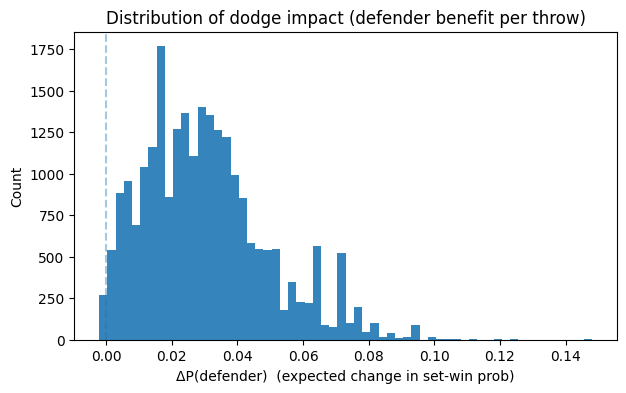

In [ ]:
plt.figure(figsize=(7,4))
plt.hist(dodge_df["defender_delta"], bins=60, alpha=0.9)
plt.axvline(0, ls="--", alpha=0.4)
plt.title("Distribution of dodge impact (defender benefit per throw)")
plt.xlabel("ΔP(defender)  (expected change in set-win prob)")
plt.ylabel("Count")
plt.show()


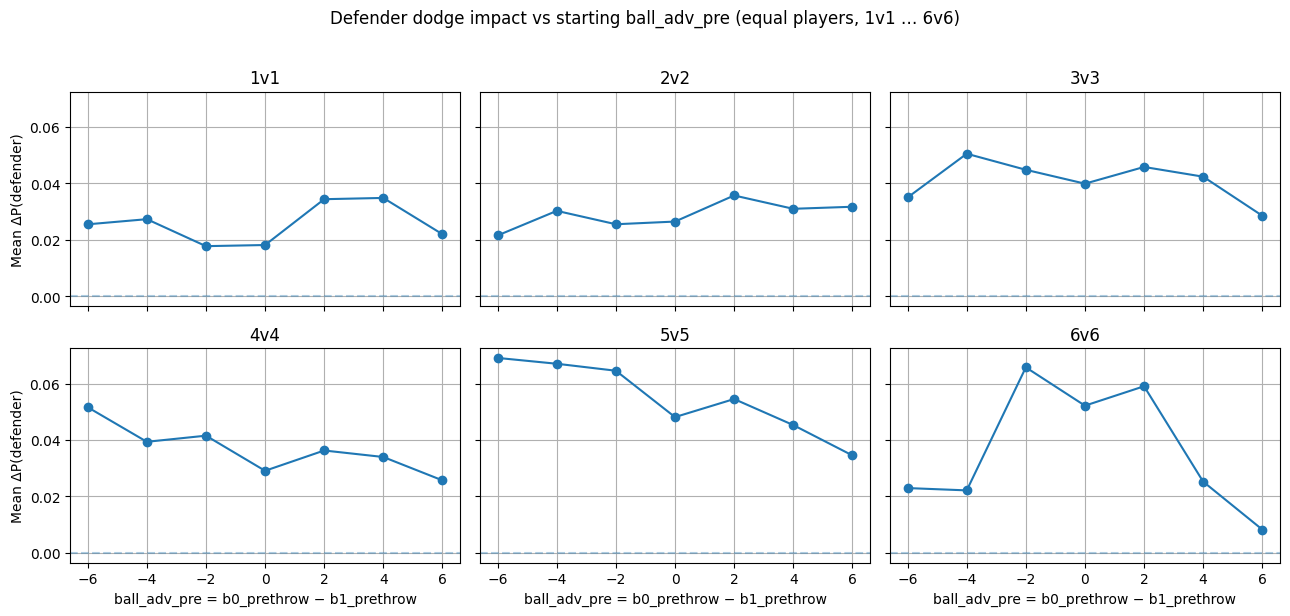

In [ ]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(13,6), sharex=True, sharey=True)
axes = axes.ravel()

domain = sorted(dodge_df["ball_adv_pre"].unique())

for k in range(1,7):
    ax = axes[k-1]
    sub = dodge_df[(dodge_df["t0"]==k) & (dodge_df["t1"]==k)]
    if sub.empty:
        ax.set_title(f"{k}v{k} (no throws)"); ax.axis("off"); continue
    curve = (sub.groupby("ball_adv_pre")["defender_delta"]
                .mean().reindex(domain))
    ax.plot(domain, curve.values, marker="o")
    ax.axhline(0.0, ls="--", alpha=0.35)
    ax.set_title(f"{k}v{k}")
    ax.grid(True)

fig.suptitle("Defender dodge impact vs starting ball_adv_pre (equal players, 1v1 … 6v6)", y=1.02)
for ax in axes[::cols]: ax.set_ylabel("Mean ΔP(defender)")
for ax in axes[-cols:]: ax.set_xlabel("ball_adv_pre = b0_prethrow − b1_prethrow")
plt.tight_layout()
plt.show()


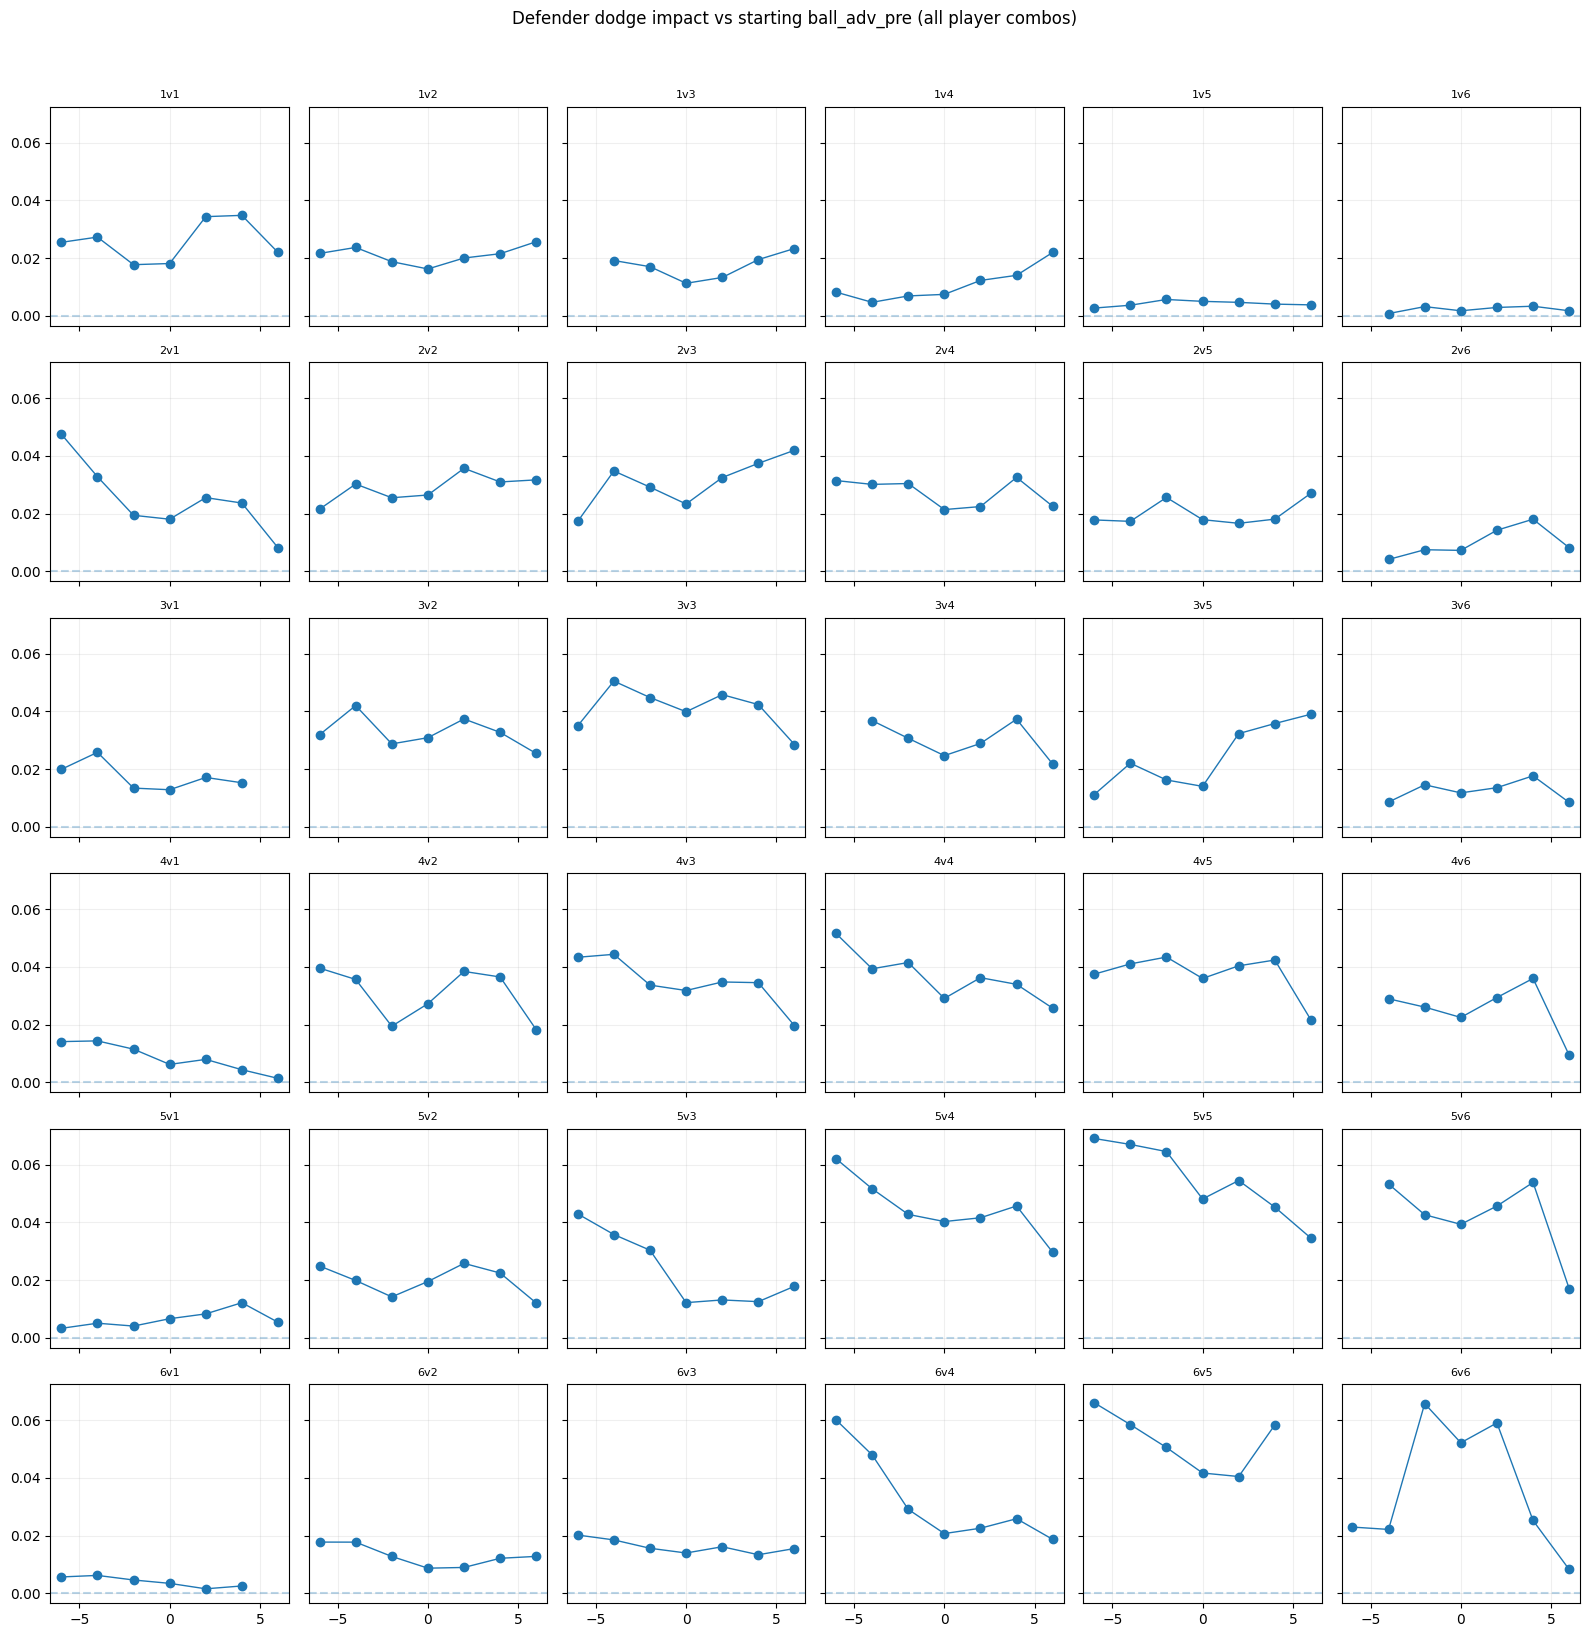

In [ ]:
rows, cols = 6, 6
fig, axes = plt.subplots(rows, cols, figsize=(16,16), sharex=True, sharey=True)
domain = sorted(dodge_df["ball_adv_pre"].unique())

for i in range(6):
    for j in range(6):
        t0p, t1p = i+1, j+1
        ax = axes[i, j]
        sub = dodge_df[(dodge_df["t0"]==t0p) & (dodge_df["t1"]==t1p)]
        if sub.empty:
            ax.axis("off"); ax.set_title(f"{t0p}v{t1p} (no throws)", fontsize=8); continue
        curve = (sub.groupby("ball_adv_pre")["defender_delta"]
                    .mean().reindex(domain))
        ax.plot(domain, curve.values, marker="o", linewidth=1)
        ax.axhline(0.0, ls="--", alpha=0.3)
        ax.set_title(f"{t0p}v{t1p}", fontsize=8)
        ax.grid(True, alpha=0.2)

fig.suptitle("Defender dodge impact vs starting ball_adv_pre (all player combos)", y=1.02)
plt.tight_layout()
plt.show()


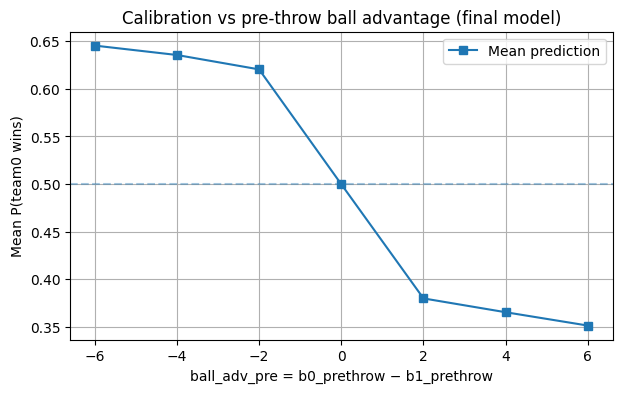

,ball_adv_pre,mean_pred,count
0,-6,0.645231,1038
1,-4,0.635356,3139
2,-2,0.620251,11674
3,0,0.499686,16512
4,2,0.379834,11674
5,4,0.365322,3139
6,6,0.351313,1038


In [ ]:
# Build a "state view" from predictions for inspection
vis = pred_all.copy()  # from your K-fold save
vis["ball_adv_pre"] = vis["b0_prethrow"] - vis["b1_prethrow"]
tmp = (vis.groupby("ball_adv_pre")["p_final"]
          .agg(mean_pred="mean", count="size")
          .reset_index())

plt.figure(figsize=(7,4))
plt.plot(tmp["ball_adv_pre"], tmp["mean_pred"], marker="s", label="Mean prediction")
plt.axhline(0.5, ls="--", alpha=0.4)
plt.title("Calibration vs pre-throw ball advantage (final model)")
plt.xlabel("ball_adv_pre = b0_prethrow − b1_prethrow")
plt.ylabel("Mean P(team0 wins)")
plt.grid(True); plt.legend(); plt.show()

tmp.sort_values("ball_adv_pre")


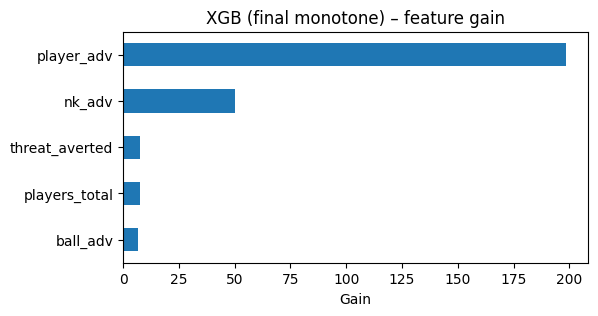

ball_adv            6.789186
players_total       7.553428
threat_averted      7.600103
nk_adv             50.191315
player_adv        198.464005
dtype: float64


In [ ]:
# Gain-based importance
gain = xgb_mono_final.get_booster().get_score(importance_type="gain")
# Put all features so missing ones show as 0
feat_order = ["player_adv","players_total","ball_adv","nk_adv","threat_averted"]
imp = pd.Series({f: gain.get(f, 0.0) for f in feat_order}).sort_values()

plt.figure(figsize=(6,3))
imp.plot(kind="barh")
plt.title("XGB (final monotone) – feature gain")
plt.xlabel("Gain")
plt.show()

print(imp)


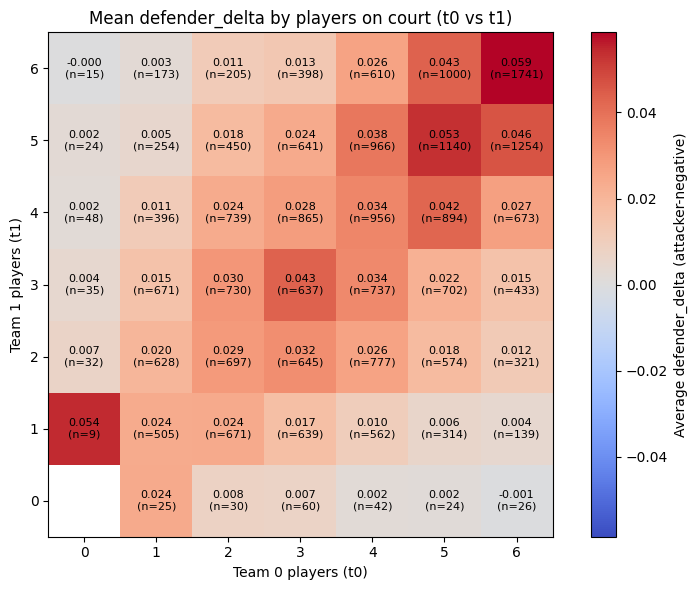

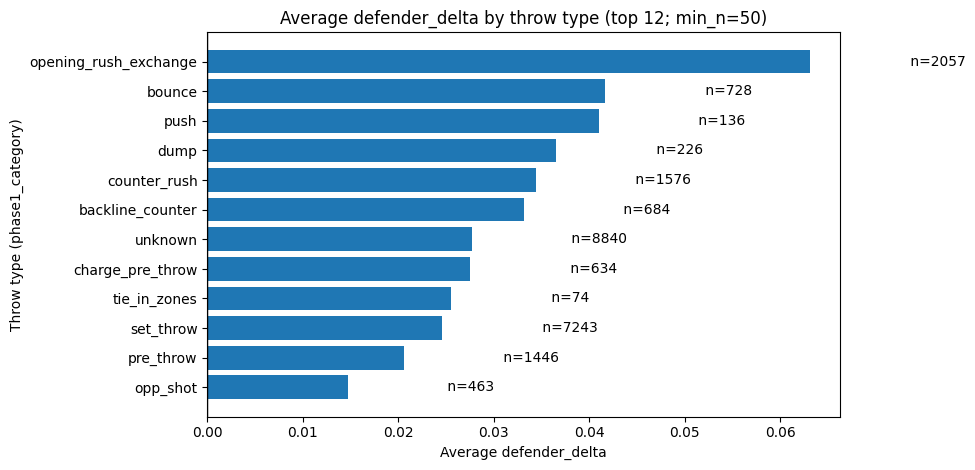

In [ ]:
# ============================================
# Heatmap & bar chart from dodge_df
#  - Heatmap: mean defender_delta by (t0, t1)
#  - Bar chart: phase1_category vs average defender_delta
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If dodge_df isn't in memory, try to load it from disk (adjust path if needed)
try:
    _ = dodge_df
except NameError:
    # Fallback path — change this if your CSV lives elsewhere
    fallback_path = os.path.join(OUT_DIR if 'OUT_DIR' in globals() else '.', "dodge_impact_rows.csv")
    print(f"[info] Loading dodge_df from {fallback_path}")
    dodge_df = pd.read_csv(fallback_path)

# --- Basic hygiene
df = dodge_df.copy()
for col in ["t0","t1","defender_delta"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["t0","t1","defender_delta"])
df["t0"] = df["t0"].astype(int)
df["t1"] = df["t1"].astype(int)

# ============================================
# 1) Heatmap: mean defender_delta by (t0, t1)
# ============================================
# Build mean grid and (optional) counts grid
mean_grid = (
    df.pivot_table(index="t1", columns="t0", values="defender_delta", aggfunc="mean")
      .reindex(index=range(0, df["t1"].max()+1), columns=range(0, df["t0"].max()+1))
)
count_grid = (
    df.pivot_table(index="t1", columns="t0", values="defender_delta", aggfunc="size")
      .reindex_like(mean_grid).fillna(0).astype(int)
)

# Symmetric color limits around zero (nice for +/- impact)
vmax = np.nanmax(np.abs(mean_grid.values))
vmax = 0.001 if not np.isfinite(vmax) or vmax == 0 else vmax  # guard tiny/empty

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(mean_grid.values, origin="lower", cmap="coolwarm", vmin=-vmax, vmax=vmax)
ax.set_title("Mean defender_delta by players on court (t0 vs t1)")
ax.set_xlabel("Team 0 players (t0)")
ax.set_ylabel("Team 1 players (t1)")

# Ticks / labels
ax.set_xticks(np.arange(mean_grid.shape[1]))
ax.set_yticks(np.arange(mean_grid.shape[0]))
ax.set_xticklabels(mean_grid.columns)
ax.set_yticklabels(mean_grid.index)

# Optional: annotate each cell with mean (rounded) and n (counts)
for y in range(mean_grid.shape[0]):
    for x in range(mean_grid.shape[1]):
        m = mean_grid.values[y, x]
        n = count_grid.values[y, x]
        if np.isfinite(m) and n > 0:
            ax.text(x, y, f"{m:.3f}\n(n={n})", ha="center", va="center", fontsize=8)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average defender_delta (attacker-negative)")

plt.tight_layout()
plt.show()

# ============================================
# 2) Bar chart: throw type vs average defender_delta
# ============================================
# Prepare data
if "phase1_category" not in df.columns:
    df["phase1_category"] = "(unlabeled)"
df["phase1_category"] = df["phase1_category"].astype(str)

by_type = (
    df.groupby("phase1_category", dropna=False)
      .agg(mean_defender_delta=("defender_delta","mean"),
           n=("defender_delta","size"))
      .reset_index()
)

# Keep categories with enough samples; sort by mean impact
min_n = 50  # tweak if you want more/less strict filtering
plot_df = by_type[by_type["n"] >= min_n].sort_values("mean_defender_delta", ascending=False)

# Plot top K (or all)
K = 20
plot_df_top = plot_df.head(K)

fig, ax = plt.subplots(figsize=(10, max(4, 0.4*len(plot_df_top))))
ax.barh(plot_df_top["phase1_category"], plot_df_top["mean_defender_delta"])
ax.axvline(0.0, color="black", linewidth=1)
ax.invert_yaxis()

ax.set_xlabel("Average defender_delta")
ax.set_ylabel("Throw type (phase1_category)")
ax.set_title(f"Average defender_delta by throw type (top {len(plot_df_top)}; min_n={min_n})")

# Annotate bars with n
for i, (m, n) in enumerate(zip(plot_df_top["mean_defender_delta"], plot_df_top["n"])):
    ax.text(m + (0.01 if m >= 0 else -0.01), i, f" n={n}", va="center",
            ha="left" if m >= 0 else "right")

plt.tight_layout()
plt.show()


new

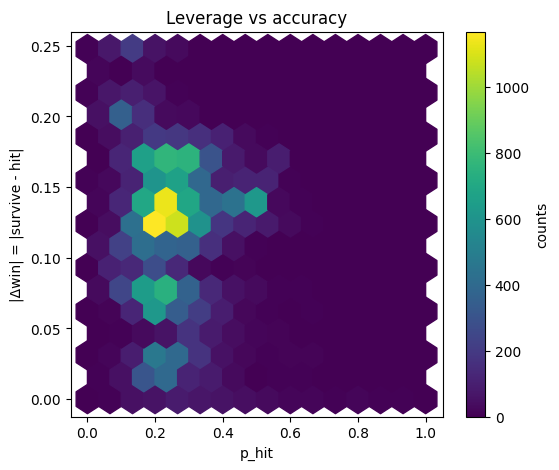

In [ ]:
tmp = dodge_df.copy()
tmp["leverage"] = (tmp["p_win_survive"] - tmp["p_win_hit"]).abs()
plt.figure(figsize=(6,5))
plt.hexbin(tmp["p_hit"], tmp["leverage"], gridsize=15, extent=[0,1,0,tmp["leverage"].max()])
plt.xlabel("p_hit"); plt.ylabel("|Δwin| = |survive - hit|"); plt.title("Leverage vs accuracy")
plt.colorbar(label="counts"); plt.show()


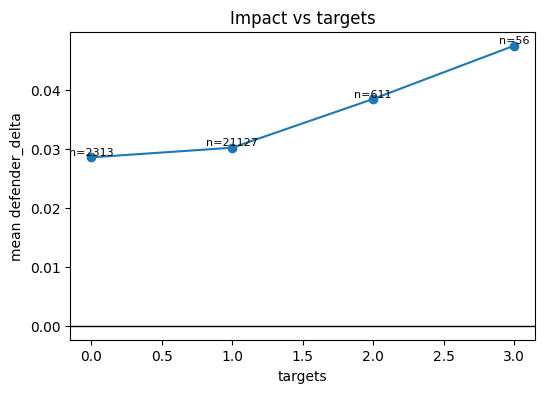

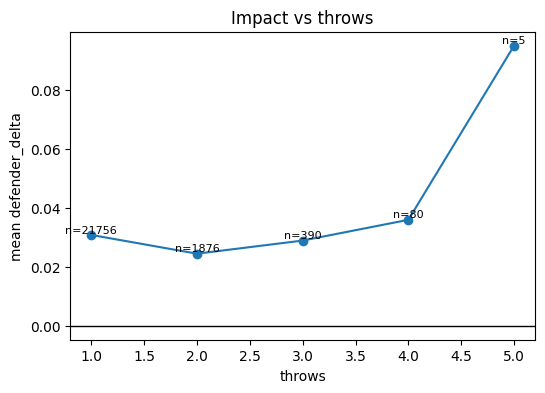

In [ ]:
for col in ["targets","throws"]:
    g = (dodge_df
         .groupby(col, dropna=False)["defender_delta"]
         .agg(["mean","count"])
         .reset_index()
         .sort_values(col))
    plt.figure(figsize=(6,4))
    plt.plot(g[col], g["mean"], marker="o")
    for x, m, n in zip(g[col], g["mean"], g["count"]):
        plt.text(x, m, f"n={n}", ha="center", va="bottom", fontsize=8)
    plt.axhline(0, color="k", lw=1)
    plt.xlabel(col); plt.ylabel("mean defender_delta"); plt.title(f"Impact vs {col}")
    plt.show()


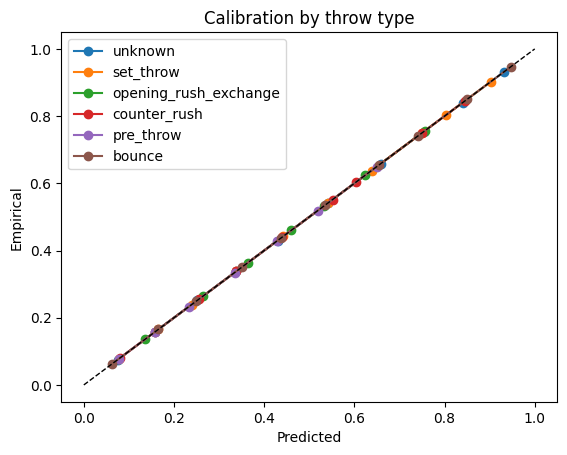

In [ ]:
N = 6
top_types = dodge_df["phase1_category"].value_counts().head(N).index
cal = []
for c in top_types:
    dfc = dodge_df[dodge_df["phase1_category"] == c]
    bins = np.clip((dfc["p_hit"]*10).astype(int), 0, 9)
    s = dfc.groupby(bins).agg(p_pred=("p_hit","mean"),
                              p_true=("p_hit","mean"),  # replace with empirical p if you store it
                              n=("p_hit","size")).reset_index(drop=True)
    s["type"] = c; cal.append(s)
cal = pd.concat(cal, ignore_index=True)
for c in top_types:
    sub = cal[cal["type"]==c]
    plt.plot(sub["p_pred"], sub["p_true"], marker="o", label=c)
plt.plot([0,1],[0,1],"k--",lw=1); plt.legend(); plt.xlabel("Predicted"); plt.ylabel("Empirical")
plt.title("Calibration by throw type"); plt.show()


In [ ]:
# =========================
# Dodgeball impact: quick EDA plot pack
# Requires: dodge_df with at least
#   ['p_hit','p_win_survive','p_win_hit','defender_delta','attacker_delta',
#    't0','t1','b0_prethrow','b1_prethrow','players_total','ball_adv',
#    'phase1_category','targets','throws']
# Optionally: train_df with 'p_label' etc. (some plots will use it if present)
# =========================
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = ROOT if 'ROOT' in globals() else "."
os.makedirs(ROOT, exist_ok=True)

if 'dodge_df' not in globals():
    raise RuntimeError("dodge_df not found. Build it first.")

df = dodge_df.copy()

# --- derived columns
df["players_total"] = df.get("players_total", df["t0"] + df["t1"])
df["ball_adv"]      = df.get("ball_adv", df["b0_prethrow"] - df["b1_prethrow"])
df["balls_total"]   = df.get("balls_total", df["b0_prethrow"] + df["b1_prethrow"])
df["leverage"]      = (df["p_win_survive"] - df["p_win_hit"]).abs()
df["swing"]         = df["p_hit"] * (df["p_win_survive"] - df["p_win_hit"])   # signed
df["exp_gain_def"]  = df["defender_delta"]                                    # alias
df["exp_gain_att"]  = df["attacker_delta"]

# -------- helpers
def _save(fig, name):
    path = os.path.join(ROOT, name)
    fig.savefig(path, dpi=140, bbox_inches="tight")
    plt.close(fig)
    print("Saved ->", path)

def _binned_2d_mean(x, y, v, bins_x, bins_y):
    H_sum, xedges, yedges = np.histogram2d(x, y, bins=[bins_x, bins_y], weights=v)
    H_cnt, _, _          = np.histogram2d(x, y, bins=[bins_x, bins_y])
    with np.errstate(invalid="ignore", divide="ignore"):
        H_mean = H_sum / np.maximum(H_cnt, 1)
    H_mean[H_cnt == 0] = np.nan
    return H_mean.T, xedges, yedges, H_cnt.T  # transpose for imshow orientation

# =========================
# A) Heatmap: players_total vs ball_adv -> mean defender_delta
# =========================
bins_players = np.arange(df["players_total"].min()-0.5, df["players_total"].max()+1.5, 1)
bins_balladv = np.arange(df["ball_adv"].min()-0.5, df["ball_adv"].max()+1.5, 1)

H, xe, ye, C = _binned_2d_mean(
    df["players_total"].values,
    df["ball_adv"].values,
    df["exp_gain_def"].values,
    bins_players, bins_balladv
)
fig = plt.figure(figsize=(8,6))
im = plt.imshow(H, origin="lower",
                extent=[xe[0], xe[-1], ye[0], ye[-1]],
                aspect="auto", cmap="viridis")
plt.colorbar(im, label="mean defender Δwin")
plt.xlabel("players_total")
plt.ylabel("ball_adv (team0 - team1)")
plt.title("Defender impact heatmap")
_save(fig, "impact_heatmap_players_balladv.png")

# =========================
# B) Heatmap: t0 vs t1 -> mean p_hit
# =========================
bins_t = np.arange(min(df["t0"].min(),df["t1"].min())-0.5,
                   max(df["t0"].max(),df["t1"].max())+1.5, 1)
H, xe, ye, C = _binned_2d_mean(df["t0"].values, df["t1"].values, df["p_hit"].values,
                               bins_t, bins_t)
fig = plt.figure(figsize=(7,6))
im = plt.imshow(H, origin="lower", extent=[xe[0], xe[-1], ye[0], ye[-1]],
                aspect="equal", cmap="magma")
plt.colorbar(im, label="mean p_hit")
plt.xlabel("t0 on court")
plt.ylabel("t1 on court")
plt.title("Hit probability by player counts")
_save(fig, "phit_heatmap_t0_t1.png")

# =========================
# C) Bar: phase1_category vs average defender_delta (top K by count)
# =========================
K = 20
by_cat = (df.groupby("phase1_category", dropna=False)
            .agg(n=("exp_gain_def","size"),
                 mean_def=("exp_gain_def","mean"),
                 sem=("exp_gain_def", lambda s: s.std(ddof=1)/np.sqrt(max(len(s),1))))
            .sort_values("n", ascending=False).head(K))
fig = plt.figure(figsize=(10,6))
ypos = np.arange(len(by_cat))
plt.barh(ypos, by_cat["mean_def"], xerr=by_cat["sem"], alpha=0.85)
plt.yticks(ypos, by_cat.index)
plt.xlabel("mean defender Δwin (± s.e.)")
plt.title(f"Average defender impact by throw type (top {K} by count)")
plt.gca().invert_yaxis()
_save(fig, "bar_throwtype_mean_defender_delta.png")

# =========================
# D) Bars: throws (z) and targets (x) vs averages
# =========================
for col, label in [("throws","throws (session z)"), ("targets","targets (session x)")]:
    g = (df.groupby(col)
           .agg(n=("exp_gain_def","size"),
                mean_def=("exp_gain_def","mean"),
                mean_phit=("p_hit","mean"),
                mean_lev=("leverage","mean"))
           .sort_index())
    fig = plt.figure(figsize=(8,5))
    plt.bar(g.index.astype(str), g["mean_def"])
    plt.xlabel(label); plt.ylabel("mean defender Δwin")
    plt.title(f"Impact vs {label}")
    _save(fig, f"bar_{col}_vs_mean_defender_delta.png")

    fig = plt.figure(figsize=(8,5))
    w = 0.35
    idx = np.arange(len(g))
    plt.bar(idx - w/2, g["mean_phit"], width=w, label="mean p_hit")
    plt.bar(idx + w/2, g["mean_lev"], width=w, label="mean leverage")
    plt.xticks(idx, g.index.astype(str))
    plt.ylabel("rate / leverage"); plt.legend()
    plt.title(f"Accuracy & leverage vs {label}")
    _save(fig, f"bar_{col}_vs_phit_leverage.png")

# =========================
# E) Curves: binned p_hit vs expected swing (attacker & defender)
# =========================
bins = np.linspace(0,1,21)
df["bin"] = np.clip(np.digitize(df["p_hit"], bins)-1, 0, len(bins)-2)
gb = df.groupby("bin")
cur = gb.agg(
    p_center=("p_hit", "mean"),
    n=("p_hit","size"),
    def_mean=("exp_gain_def","mean"),
    att_mean=("exp_gain_att","mean"),
    lev_mean=("leverage","mean"),
).reset_index()
fig = plt.figure(figsize=(8,5))
plt.plot(cur["p_center"], cur["def_mean"], marker="o", label="defender")
plt.plot(cur["p_center"], -cur["att_mean"], marker="o", label="attacker (negated)")
plt.xlabel("p_hit (binned)"); plt.ylabel("expected Δwin")
plt.title("Expected swing vs accuracy")
plt.grid(alpha=0.3); plt.legend()
_ = _save(fig, "curve_phit_vs_expected_swing.png")

# =========================
# F) Cumulative contribution: top-N throws by |attacker_delta|
# =========================
tmp = df.assign(abs_att=np.abs(df["exp_gain_att"])).sort_values("abs_att", ascending=False)
tmp["cum_frac_contrib"] = tmp["abs_att"].cumsum()/tmp["abs_att"].sum()
tmp["cum_frac_throws"]  = np.arange(1, len(tmp)+1)/len(tmp)
fig = plt.figure(figsize=(7,5))
plt.plot(tmp["cum_frac_throws"], tmp["cum_frac_contrib"])
plt.xlabel("Top fraction of throws"); plt.ylabel("Fraction of total |attacker impact|")
plt.title("Concentration of value (Pareto curve)")
plt.grid(alpha=0.3)
_save(fig, "curve_pareto_attacker_impact.png")

# =========================
# G) Heatmap: players_total vs p_hit -> mean leverage (where accuracy matters)
# =========================
bins_players = np.arange(df["players_total"].min()-0.5, df["players_total"].max()+1.5, 1)
bins_phit    = np.linspace(0,1,21)
H, xe, ye, C = _binned_2d_mean(df["players_total"].values, df["p_hit"].values,
                               df["leverage"].values, bins_players, bins_phit)
fig = plt.figure(figsize=(8,6))
im = plt.imshow(H, origin="lower", extent=[xe[0], xe[-1], ye[0], ye[-1]],
                aspect="auto", cmap="plasma")
plt.colorbar(im, label="mean leverage")
plt.xlabel("players_total"); plt.ylabel("p_hit")
plt.title("Where leverage is high")
_save(fig, "leverage_heatmap_players_vs_phit.png")

# =========================
# H) (Optional) Calibration vs p_label if train_df exists
# =========================
if 'train_df' in globals() and not train_df.empty and "p_label" in train_df.columns:
    # Re-join predictions for those rows if you want; otherwise show empirical p_label by throw type
    g = (train_df.groupby("phase1_category", dropna=False)
                  .agg(n=("p_label","size"), p_true=("p_label","mean"))
                  .sort_values("n", ascending=False).head(20))
    fig = plt.figure(figsize=(10,6))
    plt.barh(np.arange(len(g)), g["p_true"])
    plt.yticks(np.arange(len(g)), g.index)
    plt.xlabel("empirical p_label (y/z)"); plt.title("Empirical hit rate by throw type (training)")
    plt.gca().invert_yaxis()
    _save(fig, "training_empirical_by_throwtype.png")
else:
    print("[info] train_df not present; skipped training-calibration plot.")


Saved -> /content/drive/MyDrive/Winrate predictions/impact_heatmap_players_balladv.png
Saved -> /content/drive/MyDrive/Winrate predictions/phit_heatmap_t0_t1.png
Saved -> /content/drive/MyDrive/Winrate predictions/bar_throwtype_mean_defender_delta.png
Saved -> /content/drive/MyDrive/Winrate predictions/bar_throws_vs_mean_defender_delta.png
Saved -> /content/drive/MyDrive/Winrate predictions/bar_throws_vs_phit_leverage.png
Saved -> /content/drive/MyDrive/Winrate predictions/bar_targets_vs_mean_defender_delta.png
Saved -> /content/drive/MyDrive/Winrate predictions/bar_targets_vs_phit_leverage.png
Saved -> /content/drive/MyDrive/Winrate predictions/curve_phit_vs_expected_swing.png
Saved -> /content/drive/MyDrive/Winrate predictions/curve_pareto_attacker_impact.png
Saved -> /content/drive/MyDrive/Winrate predictions/leverage_heatmap_players_vs_phit.png
Saved -> /content/drive/MyDrive/Winrate predictions/training_empirical_by_throwtype.png


In [ ]:
# ============================================
# Add thrower_name (from definitionKey contains 'throw') and target_name
# into dodge_impact_rows.csv   — assumes event files are already time-sorted
# ============================================
import os, glob
import numpy as np
import pandas as pd

# (Colab) mount Drive if needed
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

# ---- Paths / knobs ----
ROOT           = "/content/drive/MyDrive/Winrate predictions"  # <- adjust if needed
# allow either the SLIM_with_throwtype or the plain v4 filenames
PATTERNS       = [
    os.path.join(ROOT, "**", "*_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM_with_throwtype*.xlsx"),
    os.path.join(ROOT, "**", "*_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4*.xlsx"),
]
IMPACT_CSV_IN  = os.path.join(ROOT, "dodge_impact_rows.csv")
IMPACT_CSV_OUT = os.path.join(ROOT, "dodge_impact_rows_with_names.csv")

TIME_DECIMALS  = 3    # rounding for exact-time matches
NEAREST_TOL_S  = 0.50 # seconds for nearest fallback (set to None to disable)

# ---- Helpers ----
def _norm_rid(x: str) -> str:
    """Normalize reviewid so long/short forms match (use prefix before first '-')."""
    s = str(x)
    return s.split("-")[0] if "-" in s else s

def _find_col(df, candidates, required=True):
    norm = {c.lower().replace(" ","").replace("_",""): c for c in df.columns}
    for name in candidates:
        key = name.lower().replace(" ","").replace("_","")
        if key in norm:
            return norm[key]
    if required:
        raise KeyError(f"Missing any of {candidates} in columns: {list(df.columns)}")
    return None

def _is_throw_by_defkey(defkey):
    return pd.notna(defkey) and ("throw" in str(defkey).lower())

# ---- 1) Load & normalize ALL event files ----
event_files = []
for pat in PATTERNS:
    event_files.extend(glob.glob(pat, recursive=True))
event_files = sorted(set(event_files))
if not event_files:
    raise FileNotFoundError("No event files matched the provided patterns.")

events = []
for fp in event_files:
    try:
        raw = pd.read_excel(fp)
    except Exception as e:
        print(f"[skip] {os.path.basename(fp)} -> {e}")
        continue

    rid   = _find_col(raw, ["reviewid","review_id","review","rid"])
    time  = _find_col(raw, ["time","t"])
    who   = _find_col(raw, ["who","player","name"])
    defky = _find_col(raw, ["definitionkey","defkey","definition_key"])

    df = pd.DataFrame({
        "reviewid": raw[rid].map(_norm_rid),
        "time_raw": pd.to_numeric(raw[time], errors="coerce"),
        "who":      raw[who].astype(str),
        "defkey":   raw[defky]
    }).dropna(subset=["reviewid","time_raw"])

    # Keys for matching
    df["time_key"] = df["time_raw"].round(TIME_DECIMALS)
    # STRICT throw detection: definitionKey must contain 'throw'
    df["is_throw"] = df["defkey"].apply(_is_throw_by_defkey)

    events.append(df)

events = pd.concat(events, ignore_index=True)
print(f"[events] rows: {len(events):,} | files: {len(event_files)}")

# ---- 2) Build {reviewid, time} → thrower/target mapping ----
pair_rows = []

for rid, g in events.groupby("reviewid", sort=False):
    # files are already sorted; enforce just in case
    g = g.sort_values("time_raw", kind="mergesort").reset_index(drop=True)

    throws    = g[g["is_throw"]]
    nonthrows = g[~g["is_throw"]]

    if throws.empty:
        continue

    # quick exit if no candidate target rows in this review
    if nonthrows.empty:
        for _, r in throws.iterrows():
            pair_rows.append({
                "reviewid": rid,
                "time_throw": float(r["time_raw"]),
                "time_key": float(r["time_key"]),
                "thrower_name": r["who"],
                "target_name": np.nan
            })
        continue

    # Pre-compute for speed
    nt_times = nonthrows["time_raw"].to_numpy()
    nt_names = nonthrows["who"].to_numpy()

    # Same-rounded-time map (prefer this)
    same_time_target = {t_key: sub.iloc[0]["who"]
                        for t_key, sub in nonthrows.groupby("time_key", sort=False)}

    for _, r in throws.iterrows():
        t_raw = float(r["time_raw"])
        t_key = float(r["time_key"])

        thrower = r["who"]
        target  = same_time_target.get(t_key, None)

        if target is None:  # fallback to nearest non-throw by absolute time
            idx = np.searchsorted(nt_times, t_raw)
            cand = []
            if idx > 0:             cand.append(idx-1)
            if idx < len(nt_times): cand.append(idx)
            if cand:
                best = min(cand, key=lambda j: abs(nt_times[j] - t_raw))
                if (NEAREST_TOL_S is None) or (abs(nt_times[best] - t_raw) <= NEAREST_TOL_S):
                    target = nt_names[best]

        pair_rows.append({
            "reviewid": rid,
            "time_throw": t_raw,
            "time_key": t_key,
            "thrower_name": thrower,
            "target_name": target
        })

pair_map = pd.DataFrame(pair_rows)
fill_rate = pair_map["target_name"].notna().mean()*100
print(f"[pair-map] throws mapped: {len(pair_map):,} | targets filled: {fill_rate:.1f}% (tol={NEAREST_TOL_S}s)")

# ---- 3) Merge into impact file (all rows in impact are throws) ----
imp = pd.read_csv(IMPACT_CSV_IN)

# normalize key columns
rid_col  = next(c for c in imp.columns if c.lower().replace("_","") in ("reviewid","reviewid","rid"))
time_col = next(c for c in imp.columns if c.lower().replace("_","") in ("time","eventtime","throwtime","t"))

imp = imp.rename(columns={rid_col:"reviewid", time_col:"time_imp"})
imp["reviewid"] = imp["reviewid"].map(_norm_rid)
imp["time_key"] = pd.to_numeric(imp["time_imp"], errors="coerce").round(TIME_DECIMALS)

# exact join on (reviewid, rounded time)
imp2 = imp.merge(
    pair_map[["reviewid","time_key","thrower_name","target_name"]],
    on=["reviewid","time_key"], how="left"
)

# optional nearest-time fallback for any remaining blanks
missing = imp2["thrower_name"].isna()
if missing.any():
    for rid, sub in pair_map.groupby("reviewid", sort=False):
        mask = (imp2["reviewid"]==rid) & missing
        if not mask.any():
            continue
        ref = sub.sort_values("time_throw")
        tt  = ref["time_throw"].to_numpy()
        tn  = ref[["thrower_name","target_name"]].to_numpy()

        q = imp2.loc[mask, "time_imp"].to_numpy()
        pos = np.searchsorted(tt, q)
        for row_idx, qi, p in zip(np.where(mask)[0], q, pos):
            cand = []
            if p>0:         cand.append(p-1)
            if p<len(tt):   cand.append(p)
            if not cand:
                continue
            best = min(cand, key=lambda j: abs(tt[j]-qi))
            if (NEAREST_TOL_S is None) or (abs(tt[best]-qi) <= NEAREST_TOL_S):
                imp2.at[row_idx, "thrower_name"] = tn[best, 0]
                imp2.at[row_idx, "target_name"]  = tn[best, 1]

# ---- Save & preview ----
imp2.to_csv(IMPACT_CSV_OUT, index=False)
print(f"[saved] {IMPACT_CSV_OUT}")
print(imp2[["reviewid","time_imp","thrower_name","target_name"]].head(12).to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[events] rows: 150,672 | files: 174
[pair-map] throws mapped: 72,321 | targets filled: 99.1% (tol=0.5s)
[saved] /content/drive/MyDrive/Winrate predictions/dodge_impact_rows_with_names.csv
reviewid  time_imp    thrower_name     target_name
01d7c3a8 16.492500   Davey Tran 29  Conor Keith 24
01d7c3a8 16.492500   Davey Tran 29  Conor Keith 24
01d7c3a8 16.492500   Davey Tran 29  Conor Keith 24
01d7c3a8 16.680000 Cat-Tuong Chu 1  Conor Keith 24
01d7c3a8 16.680000 Cat-Tuong Chu 1  Conor Keith 24
01d7c3a8 16.680000 Cat-Tuong Chu 1  Conor Keith 24
01d7c3a8 19.928694    Kent Tran 17 Tristan Tran 77
01d7c3a8 19.928694    Kent Tran 17 Tristan Tran 77
01d7c3a8 19.928694    Kent Tran 17 Tristan Tran 77
01d7c3a8 21.052632  Conor Keith 24    Kent Tran 17
01d7c3a8 21.052632  Conor Keith 24    Kent Tran 17
01d7c3a8 21.052632  Conor Keith 24    Kent Tran 17


In [ ]:
# ============================================
# De-duplicate consecutive identical rows
# ============================================
import os
import pandas as pd

ROOT = "/content/drive/MyDrive/Winrate predictions"   # adjust if needed
IN   = os.path.join(ROOT, "dodge_impact_rows_with_names.csv")
OUT  = os.path.join(ROOT, "dodge_impact_rows_with_names_dedup.csv")

df = pd.read_csv(IN)
before = len(df)

# Keep a row if it differs from the previous row in ANY column
mask = df.ne(df.shift()).any(axis=1)
df_nodup = df[mask].copy()

# Optional: if you also want to collapse duplicates that are not adjacent,
# uncomment the next line (uses a stable first-appearance rule):
# df_nodup = df_nodup.drop_duplicates(keep="first")

after = len(df_nodup)
df_nodup.to_csv(OUT, index=False)

print(f"Removed {before - after} duplicate rows. Saved → {OUT}")
print(df_nodup.head(15).to_string(index=False))


Removed 47172 duplicate rows. Saved → /content/drive/MyDrive/Winrate predictions/dodge_impact_rows_with_names_dedup.csv
reviewid  set_id                                set_key  time_imp  row_idx  t0  t1  b0_prethrow  b1_prethrow  thrower_team phase1_category  targets  throws  ball_adv_pre    p_hit  p_win_survive  p_win_hit  defender_delta  attacker_delta  time_key        thrower_name     target_name
01d7c3a8       0 01d7c3a8-0625-4e71-adc1-6420cc0f5390_0 16.492500        0   6   6            3            3             0       set_throw        1       2             0 0.246293       0.501754   0.646120        0.035556       -0.035556    16.492       Davey Tran 29  Conor Keith 24
01d7c3a8       0 01d7c3a8-0625-4e71-adc1-6420cc0f5390_0 16.680000        1   6   6            3            3             0       set_throw        1       2             0 0.246293       0.501754   0.646120        0.035556       -0.035556    16.680     Cat-Tuong Chu 1  Conor Keith 24
01d7c3a8       0 01d7c3a8-0625-